In [1]:
from datamaker_f import VideoDataGenerator, VideoDataGenerator2
from pipeline_f import build_full_model
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

## Deepfakes (HQ) dataset
-- Number of videos: 6200
-- Training set: 3472
-- Validation set: 868
-- Test set: 1860

In [2]:
# Load the dataset from the pickle file
with open("F:/video_data_unaugmented.pkl", "rb") as f:
    pickled_data = pickle.load(f)


In [3]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frame_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000' structure:
Frames count: 33
Frames labels count: 33
Micro-expression count: 99
Micro-expression labels count: 99


In [4]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items = list(pickled_data.items())
video_names, labels = zip(*[(video_name, video_info['frame_label'][0]) for video_name, video_info in pickled_data.items()])

In [5]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [6]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [7]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

3472
868
1860


In [8]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)


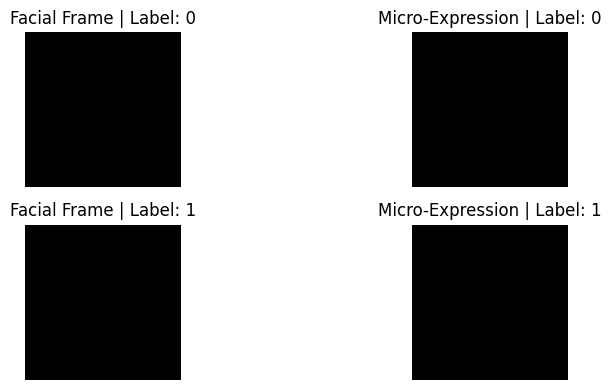

In [9]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Take a batch and unpack it
for batch in train_generator.take(1):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy().astype("uint8")

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy().astype("uint8")

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Display images for both labels
plt.figure(figsize=(10, 4))

# Display facial and micro-expression frames for label 0
plt.subplot(2, 2, 1)
plt.imshow(sample_frame_0)
plt.title("Facial Frame | Label: 0")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(sample_micro_exp_0)
plt.title("Micro-Expression | Label: 0")
plt.axis("off")

# Display facial and micro-expression frames for label 1
plt.subplot(2, 2, 3)
plt.imshow(sample_frame_1)
plt.title("Facial Frame | Label: 1")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample_micro_exp_1)
plt.title("Micro-Expression | Label: 1")
plt.axis("off")

plt.tight_layout()
plt.show()


In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [11]:
optimizer_2 = Adam(learning_rate=1e-4)

In [12]:
model_2 = build_full_model()

In [13]:
model_2.compile(
    optimizer=optimizer_2,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [14]:
history_df = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/1000


217/217 [==============================] - 544s 2s/step - loss: 0.8953 - accuracy: 0.5605 - val_loss: 0.7740 - val_accuracy: 0.5495 - lr: 1.0000e-04
Epoch 2/1000
217/217 [==============================] - 503s 2s/step - loss: 0.6336 - accuracy: 0.7054 - val_loss: 0.7725 - val_accuracy: 0.5495 - lr: 1.0000e-04
Epoch 3/1000
217/217 [==============================] - 504s 2s/step - loss: 0.4376 - accuracy: 0.8393 - val_loss: 0.8115 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 4/1000
217/217 [==============================] - 505s 2s/step - loss: 0.3276 - accuracy: 0.9035 - val_loss: 0.7673 - val_accuracy: 0.5565 - lr: 1.0000e-04
Epoch 5/1000
217/217 [==============================] - 505s 2s/step - loss: 0.2740 - accuracy: 0.9263 - val_loss: 0.8442 - val_accuracy: 0.7834 - lr: 1.0000e-04
Epoch 6/1000
217/217 [==============================] - 504s 2s/step - loss: 0.2062 - accuracy: 0.9574 - val_loss: 0.6689 - val_accuracy: 0.8917 - lr: 1.0000e-04
Epoch 7/1000
217/217 [====

In [15]:
test_loss, test_accuracy = model_2.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

117/117 [==============================] - 76s 650ms/step - loss: 0.2780 - accuracy: 0.9392
Test loss: 0.27800992131233215, Test accuracy: 0.9392473101615906


In [16]:
model_2.save("model_02_acc_9392_261124.h5")

c:\Users\USER\anaconda3\envs\Face-Swap-Detection-Model\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
model_2.save_weights("model_02_weights_261124_acc_9392.h5")

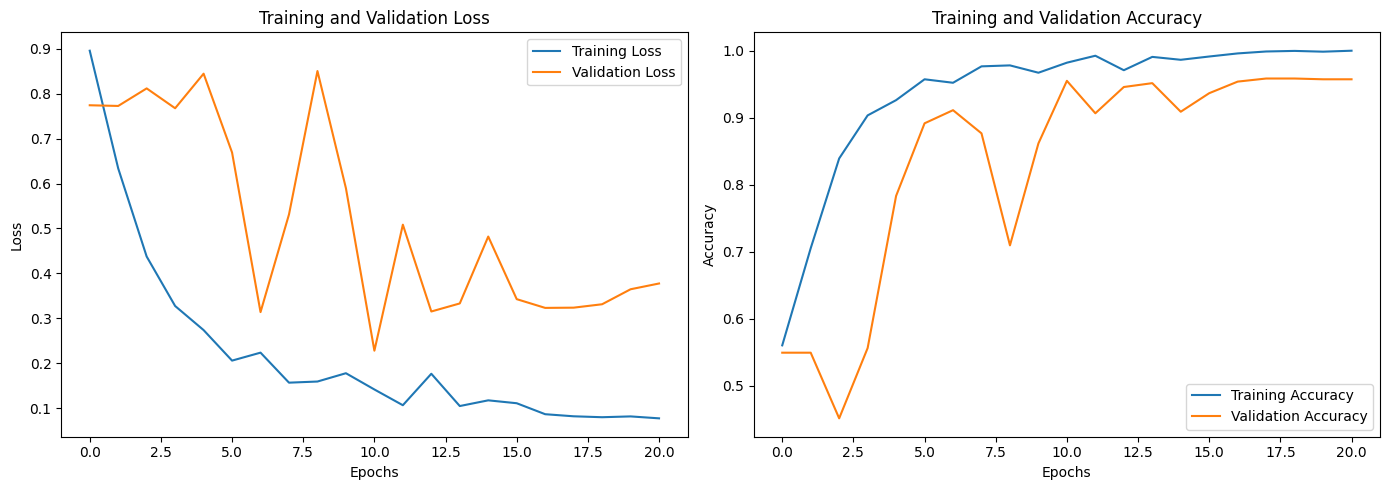

In [18]:
import matplotlib.pyplot as plt

# Plot loss and accuracy for training and validation sets
def plot_history(history):
    # Loss plot
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the history of model_2
plot_history(history_df)


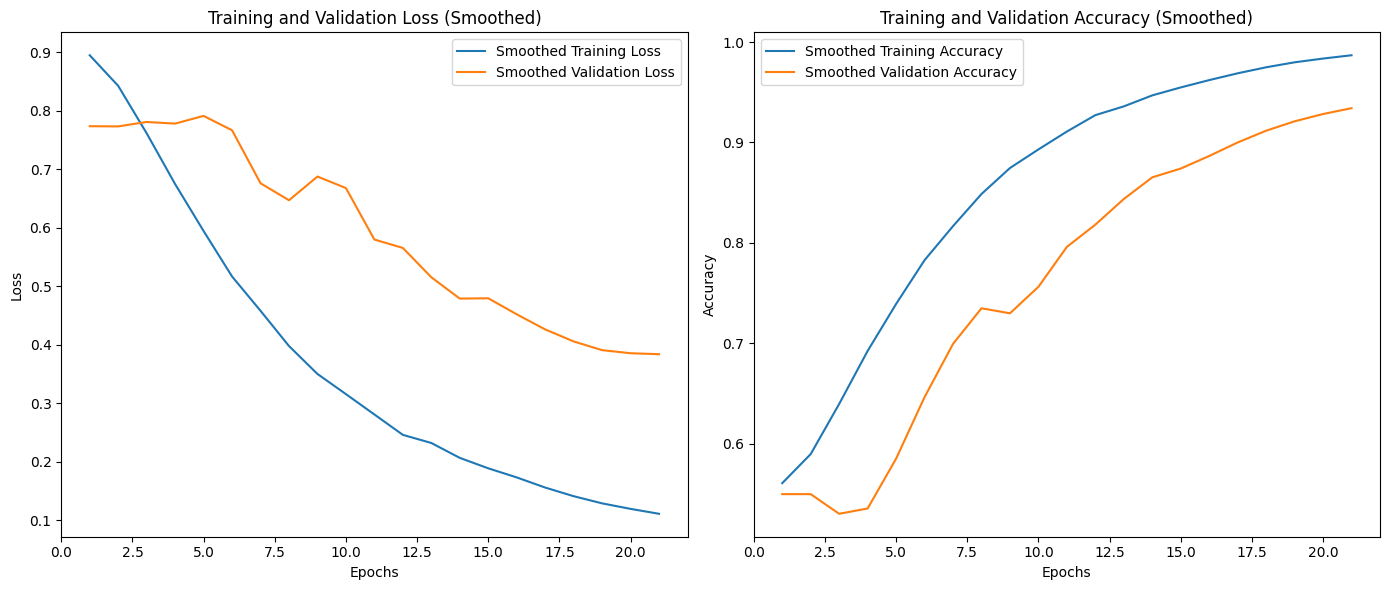

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot with smoothing
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, smooth_curve(history.history['loss']), label='Smoothed Training Loss')
    plt.plot(epochs, smooth_curve(history.history['val_loss']), label='Smoothed Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Smoothed)')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, smooth_curve(history.history['accuracy']), label='Smoothed Training Accuracy')
    plt.plot(epochs, smooth_curve(history.history['val_accuracy']), label='Smoothed Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_df)


In [21]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [22]:
test_prediction = model_2.predict(test_generator)

test_prediction_labels = np.argmax(test_prediction, axis=1)

117/117 [==============================] - 79s 644ms/step


In [23]:
# Calculate ROC-AUC Score
from sklearn.metrics import roc_auc_score


roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9844


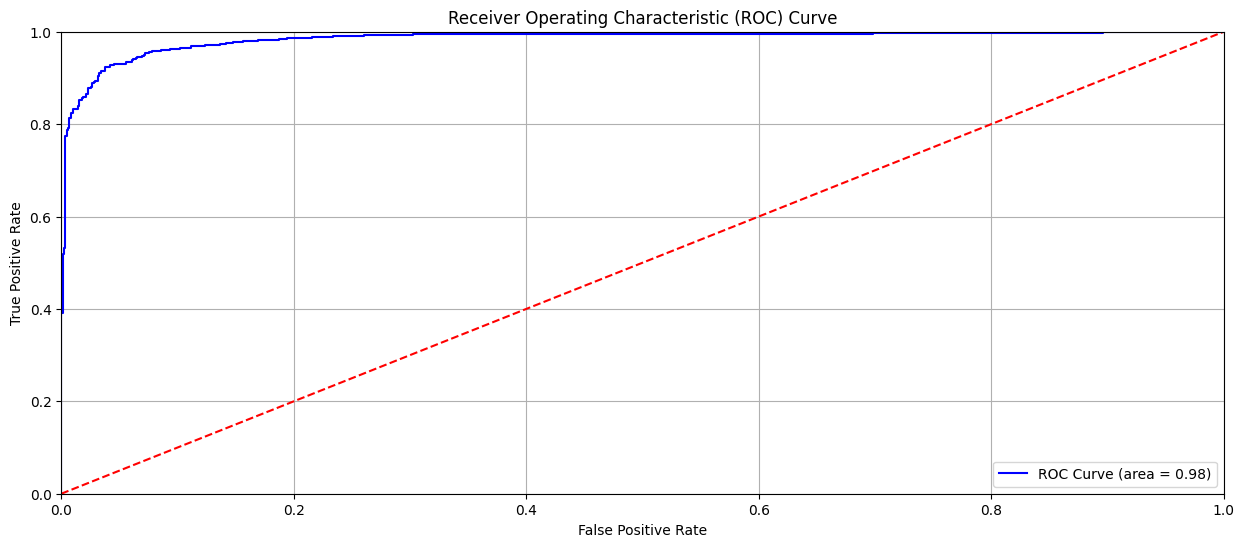

In [24]:
# Calculate ROC curve
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

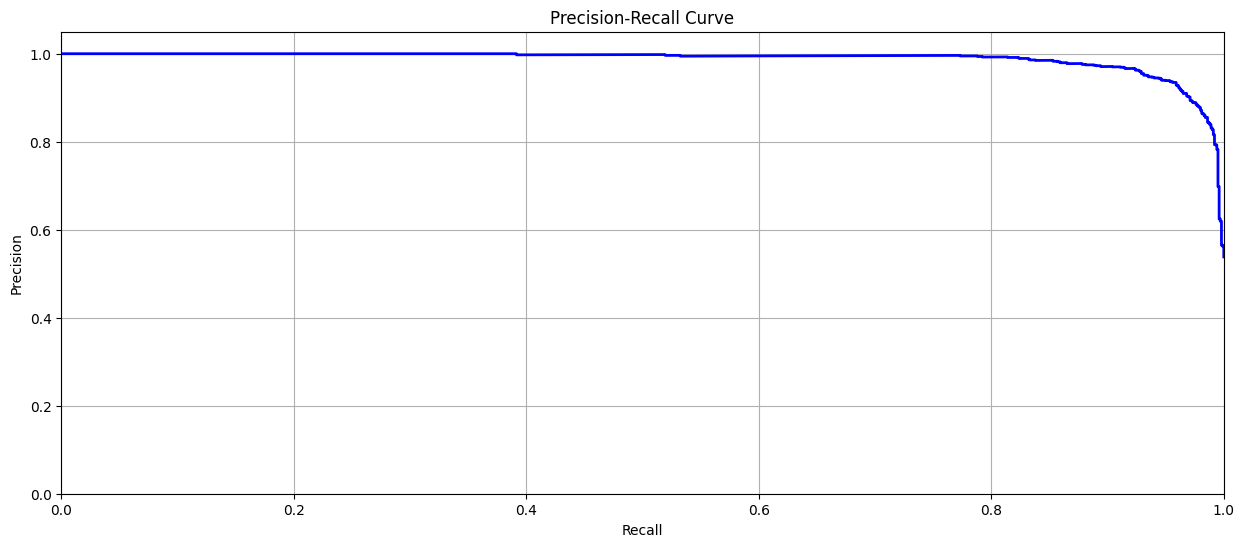

In [25]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(15, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

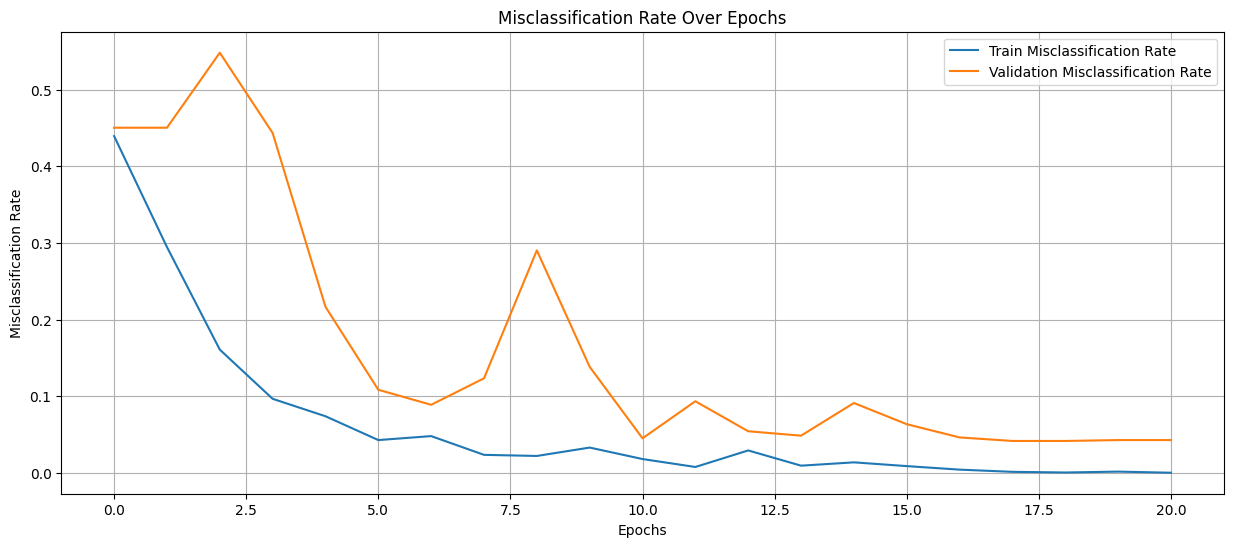

In [27]:
# Misclassification rate for train and validation data
train_misclassification = [1 - acc for acc in history_df.history['accuracy']]
val_misclassification = [1 - val_acc for val_acc in history_df.history['val_accuracy']]

# Plot misclassification rates
plt.figure(figsize=(15, 6))
plt.plot(train_misclassification, label='Train Misclassification Rate')
plt.plot(val_misclassification, label='Validation Misclassification Rate')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# save the history
with open('history_df_26112024.pkl', 'wb') as f:
    pickle.dump(history_df.history, f)

In [29]:
# Assuming test_predictions contains probabilities for the positive class
test_pred_labels = (test_prediction > 0.5).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate performance metrics
accuracy = accuracy_score(y_true, test_pred_labels)
precision = precision_score(y_true, test_pred_labels, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(y_true, test_pred_labels, average='weighted')
f1 = f1_score(y_true, test_pred_labels, average='weighted')
confusion_mat = confusion_matrix(y_true, test_pred_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.9392
Precision: 0.9392
Recall: 0.9392
F1 Score: 0.9392
Confusion Matrix:
 [[800  59]
 [ 54 947]]


In [31]:
report = classification_report(y_true, test_pred_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       859
         1.0       0.94      0.95      0.94      1001

    accuracy                           0.94      1860
   macro avg       0.94      0.94      0.94      1860
weighted avg       0.94      0.94      0.94      1860



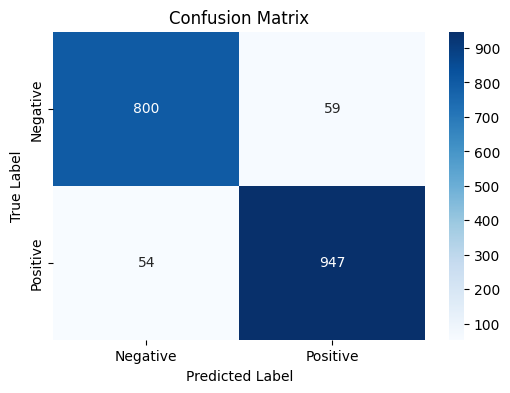

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, test_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## **Deepfakes Dataset(HQ) with 9200 videos**

In [2]:
# Load the dataset from the pickle file
with open("F:/video_data_unaugmented_9200.pkl", "rb") as f:
    pickled_data = pickle.load(f)

In [3]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frame_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000' structure:
Frames count: 33
Frames labels count: 33
Micro-expression count: 99
Micro-expression labels count: 99


In [4]:
len(pickled_data.keys())

9200

In [5]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items = list(pickled_data.items())


In [12]:
i = 0
for video_name, video_info in pickled_data.items():
    print(f"Video: {video_name}, Frame Label: {video_info.get('frame_label', 'Missing')}")
    i = i+1
    if(i == 5):
        break


Video: 000, Frame Label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Video: 000_cropped, Frame Label: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Video: 000_frame_dropout, Frame Label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Video: 000_reversed, Frame Label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Video: 000_speed_changed, Frame Label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
video_names, labels = zip(*[
    (video_name, video_info['frame_label'][0])
    for video_name, video_info in pickled_data.items()
    if 'frame_label' in video_info and len(video_info['frame_label']) > 0
])


In [14]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [15]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [16]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

5151
1288
2760


In [17]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)


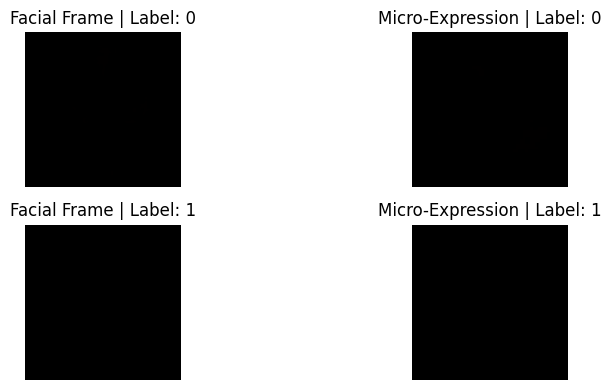

In [18]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Take a batch and unpack it
for batch in train_generator.take(1):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy().astype("uint8")

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy().astype("uint8")

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Display images for both labels
plt.figure(figsize=(10, 4))

# Display facial and micro-expression frames for label 0
plt.subplot(2, 2, 1)
plt.imshow(sample_frame_0)
plt.title("Facial Frame | Label: 0")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(sample_micro_exp_0)
plt.title("Micro-Expression | Label: 0")
plt.axis("off")

# Display facial and micro-expression frames for label 1
plt.subplot(2, 2, 3)
plt.imshow(sample_frame_1)
plt.title("Facial Frame | Label: 1")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample_micro_exp_1)
plt.title("Micro-Expression | Label: 1")
plt.axis("off")

plt.tight_layout()
plt.show()


In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [25]:
optimizer_df_9000 = Adam(learning_rate=1e-4)

In [26]:
model_df_9000 = build_full_model()

In [27]:
model_df_9000.compile(
    optimizer=optimizer_df_9000,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [28]:
history_df_9000 = model_df_9000.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/1000
322/322 [==============================] - 761s 2s/step - loss: 0.8409 - accuracy: 0.5906 - val_loss: 0.7759 - val_accuracy: 0.5116 - lr: 1.0000e-04
Epoch 2/1000
322/322 [==============================] - 727s 2s/step - loss: 0.5260 - accuracy: 0.7905 - val_loss: 0.7787 - val_accuracy: 0.4915 - lr: 1.0000e-04
Epoch 3/1000
322/322 [==============================] - 726s 2s/step - loss: 0.3505 - accuracy: 0.8938 - val_loss: 0.4614 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 4/1000
322/322 [==============================] - 726s 2s/step - loss: 0.2831 - accuracy: 0.9247 - val_loss: 0.3022 - val_accuracy: 0.9177 - lr: 1.0000e-04
Epoch 5/1000
322/322 [==============================] - 730s 2s/step - loss: 0.2164 - accuracy: 0.9583 - val_loss: 0.3850 - val_accuracy: 0.8882 - lr: 1.0000e-04
Epoch 6/1000
322/322 [==============================] - 728s 2s/step - loss: 0.2045 - accuracy: 0.9618 - val_loss: 0.5545 - val_accuracy: 0.9030 - lr: 1.0000e-04
Epoch 7/1000
322/322 [======

In [30]:
test_loss, test_accuracy = model_df_9000.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

173/173 [==============================] - 111s 639ms/step - loss: 0.2363 - accuracy: 0.9587
Test loss: 0.23627111315727234, Test accuracy: 0.958695650100708


In [32]:
model_df_9000.save("model_2_acc_9586_271124.h5")

c:\Users\USER\anaconda3\envs\Face-Swap-Detection-Model\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


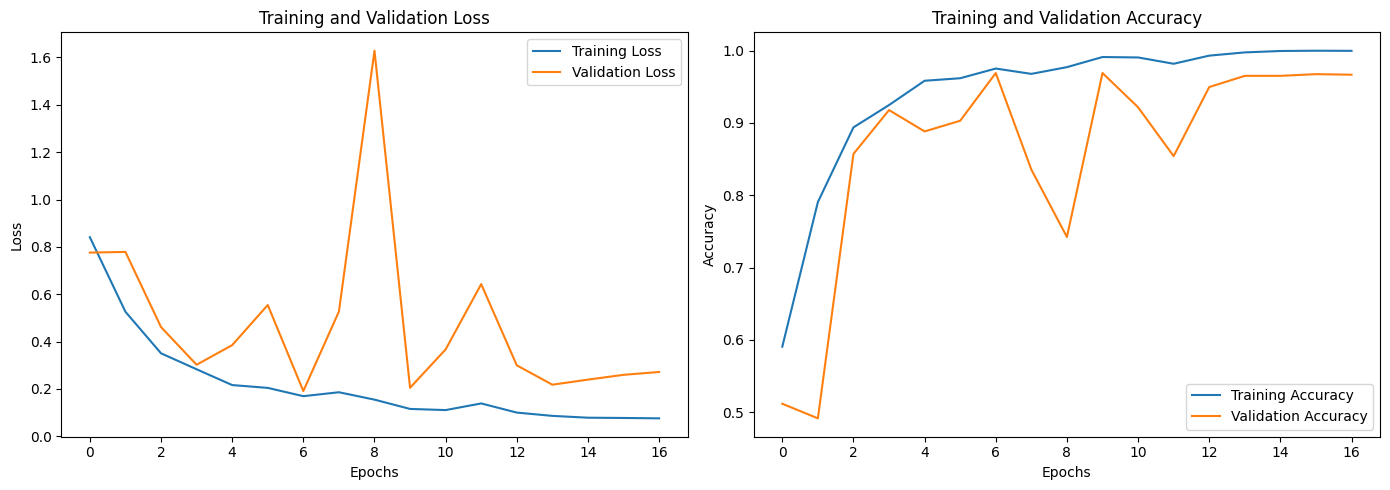

In [33]:
import matplotlib.pyplot as plt

# Plot loss and accuracy for training and validation sets
def plot_history(history):
    # Loss plot
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the history of model_2
plot_history(history_df_9000)


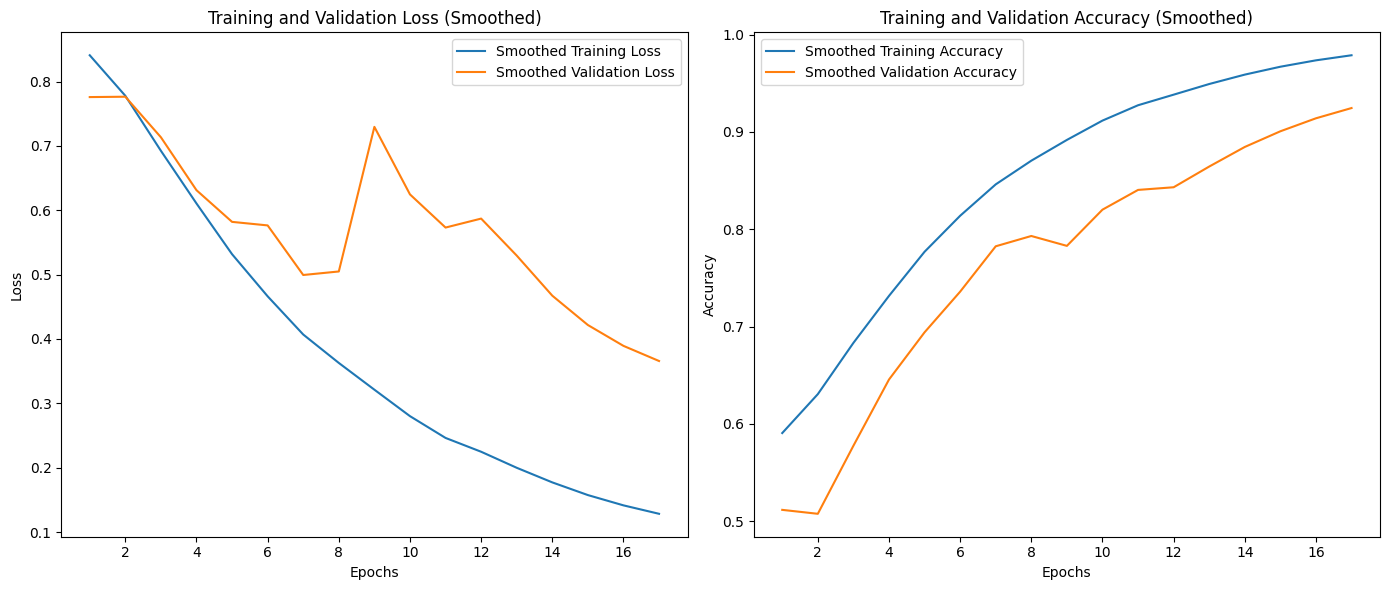

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot with smoothing
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, smooth_curve(history.history['loss']), label='Smoothed Training Loss')
    plt.plot(epochs, smooth_curve(history.history['val_loss']), label='Smoothed Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Smoothed)')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, smooth_curve(history.history['accuracy']), label='Smoothed Training Accuracy')
    plt.plot(epochs, smooth_curve(history.history['val_accuracy']), label='Smoothed Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_df_9000)


In [35]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [37]:
test_prediction = model_df_9000.predict(test_generator)

test_prediction_labels = np.argmax(test_prediction, axis=1)

173/173 [==============================] - 124s 676ms/step


In [38]:
# Calculate ROC-AUC Score
from sklearn.metrics import roc_auc_score


roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9922


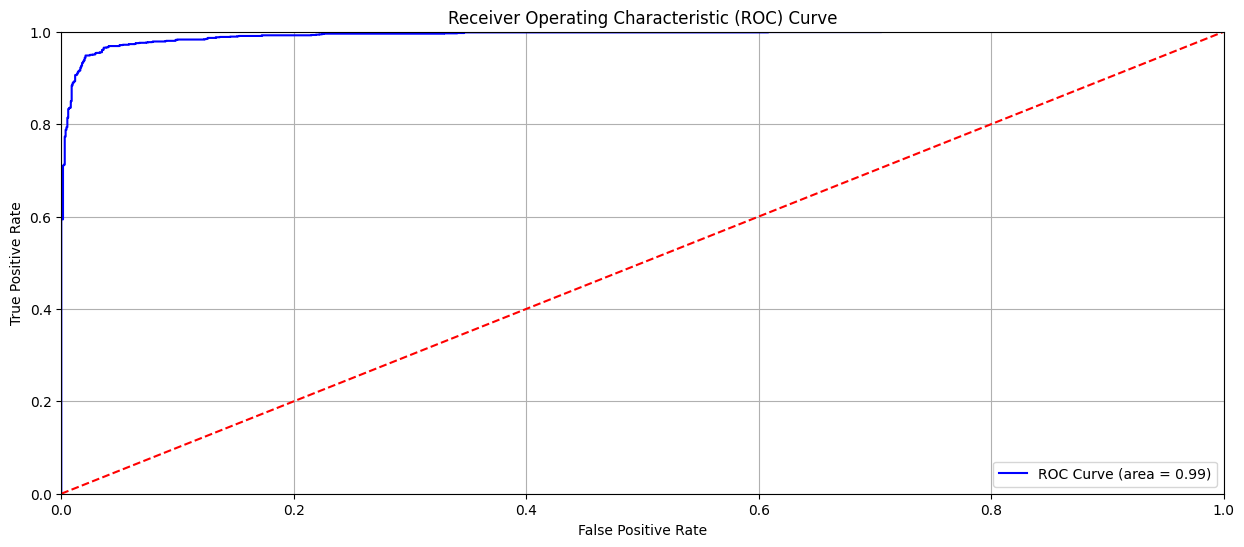

In [39]:
# Calculate ROC curve
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

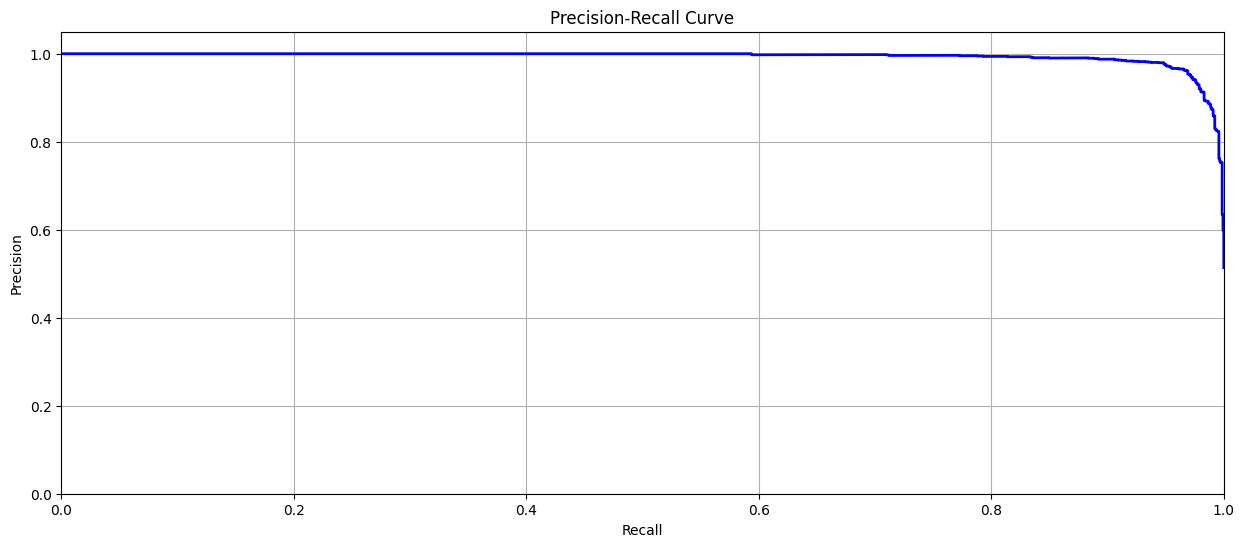

In [40]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(15, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

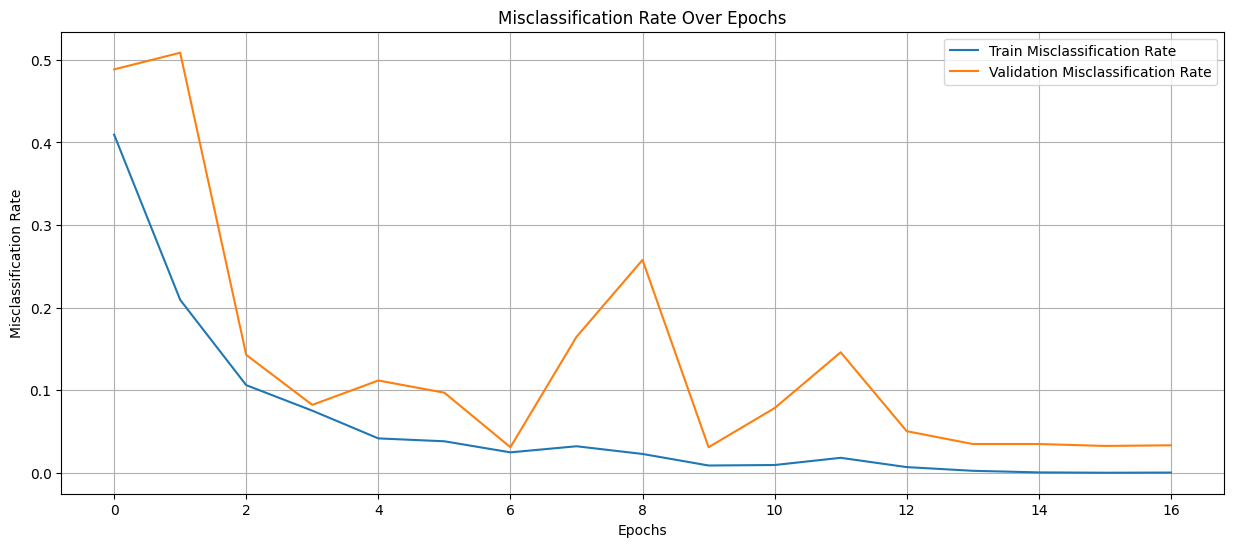

In [41]:
# Misclassification rate for train and validation data
train_misclassification = [1 - acc for acc in history_df_9000.history['accuracy']]
val_misclassification = [1 - val_acc for val_acc in history_df_9000.history['val_accuracy']]

# Plot misclassification rates
plt.figure(figsize=(15, 6))
plt.plot(train_misclassification, label='Train Misclassification Rate')
plt.plot(val_misclassification, label='Validation Misclassification Rate')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Assuming test_predictions contains probabilities for the positive class
test_pred_labels = (test_prediction > 0.5).astype(int)

In [45]:
from sklearn.metrics import classification_report
report = classification_report(y_true, test_pred_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1342
         1.0       0.98      0.94      0.96      1418

    accuracy                           0.96      2760
   macro avg       0.96      0.96      0.96      2760
weighted avg       0.96      0.96      0.96      2760



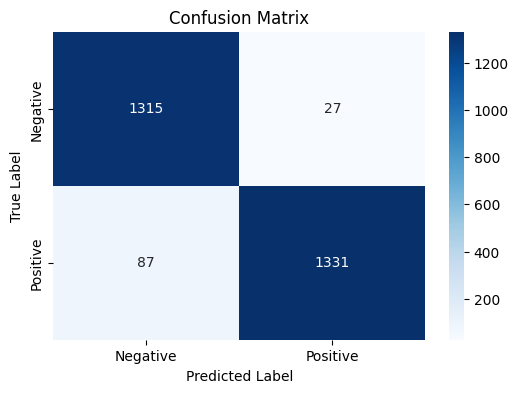

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, test_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## **FaceSwap Dataset Test** (HQ)

In [2]:
from datamaker_f import VideoDataGenerator, load_data_from_pickles
from sklearn.model_selection import train_test_split

In [3]:
pickled_data = load_data_from_pickles('D:/Projects/Face-Swap-Detection-Model/FaceSwap_pkl')

In [4]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frames_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000_003' structure:
Frames count: 300
Frames labels count: 300
Micro-expression count: 900
Micro-expression labels count: 900


In [5]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items = list(pickled_data.items())
video_names, labels = zip(*[(video_name, video_info['frames_label'][0]) for video_name, video_info in pickled_data.items()])

In [6]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [7]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [8]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

1120
280
600


In [9]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

In [10]:
for batch_data, batch_labels in train_generator:
    original_count = 0
    manipulated_count = 0
    for i, label in enumerate(batch_labels):
        if label == 0:  # Original video
            original_count += 1
        elif label == 1:  # Manipulated video
            manipulated_count += 1
    print(f"Original videos in batch: {original_count}")
    print(f"Manipulated videos in batch: {manipulated_count}")


Original videos in batch: 11
Manipulated videos in batch: 5
Original videos in batch: 11
Manipulated videos in batch: 5
Original videos in batch: 7
Manipulated videos in batch: 9
Original videos in batch: 9
Manipulated videos in batch: 7
Original videos in batch: 6
Manipulated videos in batch: 10
Original videos in batch: 6
Manipulated videos in batch: 10
Original videos in batch: 7
Manipulated videos in batch: 9
Original videos in batch: 11
Manipulated videos in batch: 5
Original videos in batch: 9
Manipulated videos in batch: 7
Original videos in batch: 5
Manipulated videos in batch: 11
Original videos in batch: 8
Manipulated videos in batch: 8
Original videos in batch: 4
Manipulated videos in batch: 12
Original videos in batch: 6
Manipulated videos in batch: 10
Original videos in batch: 10
Manipulated videos in batch: 6
Original videos in batch: 8
Manipulated videos in batch: 8
Original videos in batch: 10
Manipulated videos in batch: 6
Original videos in batch: 8
Manipulated videos

X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)


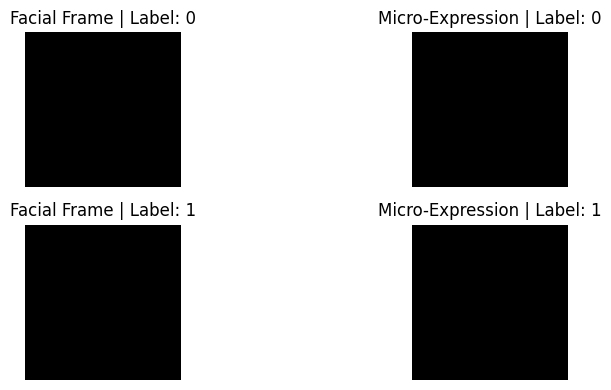

In [11]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Take a batch and unpack it
for batch in train_generator.take(1):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy().astype("uint8")

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy().astype("uint8")

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Display images for both labels
plt.figure(figsize=(10, 4))

# Display facial and micro-expression frames for label 0
plt.subplot(2, 2, 1)
plt.imshow(sample_frame_0)
plt.title("Facial Frame | Label: 0")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(sample_micro_exp_0)
plt.title("Micro-Expression | Label: 0")
plt.axis("off")

# Display facial and micro-expression frames for label 1
plt.subplot(2, 2, 3)
plt.imshow(sample_frame_1)
plt.title("Facial Frame | Label: 1")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample_micro_exp_1)
plt.title("Micro-Expression | Label: 1")
plt.axis("off")

plt.tight_layout()
plt.show()


In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=2
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=2,
    min_lr=5e-6
)

In [29]:
model_fs = build_full_model()

In [30]:
from tensorflow.keras.optimizers import AdamW

optimizer_fs = AdamW(learning_rate=1e-4, weight_decay=1e-5)

In [31]:
model_fs.compile(
    optimizer=optimizer_fs,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [32]:
history_fs = model_fs.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/1000
70/70 [==============================] - 215s 3s/step - loss: 1.1727 - accuracy: 0.5009 - val_loss: 0.7859 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/1000
70/70 [==============================] - 169s 2s/step - loss: 0.9153 - accuracy: 0.5277 - val_loss: 0.9882 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/1000
70/70 [==============================] - 169s 2s/step - loss: 0.8249 - accuracy: 0.5393 - val_loss: 1.0696 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/1000
70/70 [==============================] - 169s 2s/step - loss: 0.7956 - accuracy: 0.5696 - val_loss: 1.9177 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/1000
70/70 [==============================] - 169s 2s/step - loss: 0.7201 - accuracy: 0.6384 - val_loss: 2.3388 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/1000
70/70 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.6884
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
70/70 [=====================

In [17]:
test_loss, test_accuracy = model_fs.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

38/38 [==============================] - 24s 617ms/step - loss: 0.6472 - accuracy: 0.7267
Test loss: 0.6472444534301758, Test accuracy: 0.7266666889190674


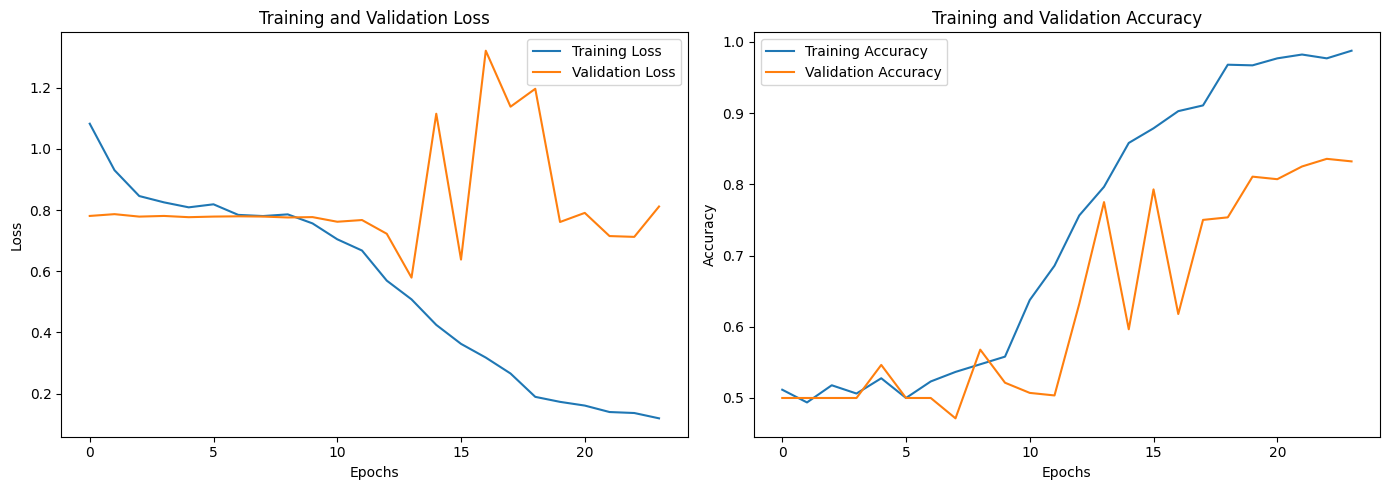

In [18]:
import matplotlib.pyplot as plt

# Plot loss and accuracy for training and validation sets
def plot_history(history):
    # Loss plot
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the history of model_2
plot_history(history_fs)


In [19]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [20]:
test_prediction = model_fs.predict(test_generator)

test_prediction_labels = np.argmax(test_prediction, axis=1)

38/38 [==============================] - 28s 645ms/step


In [21]:
# Calculate ROC-AUC Score
from sklearn.metrics import roc_auc_score


roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.7935


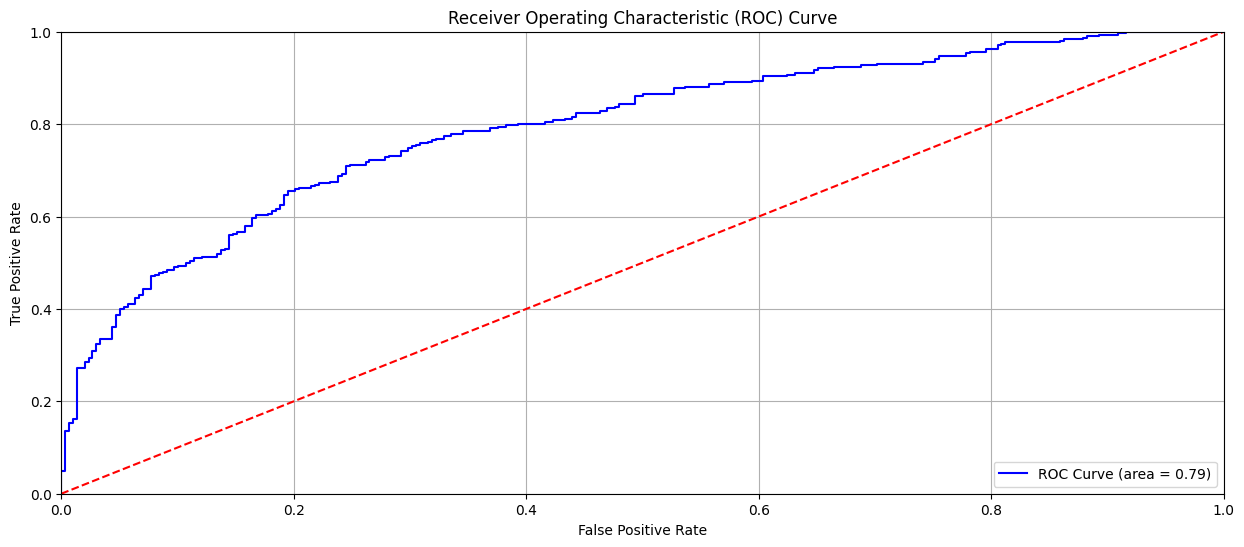

In [22]:
# Calculate ROC curve
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

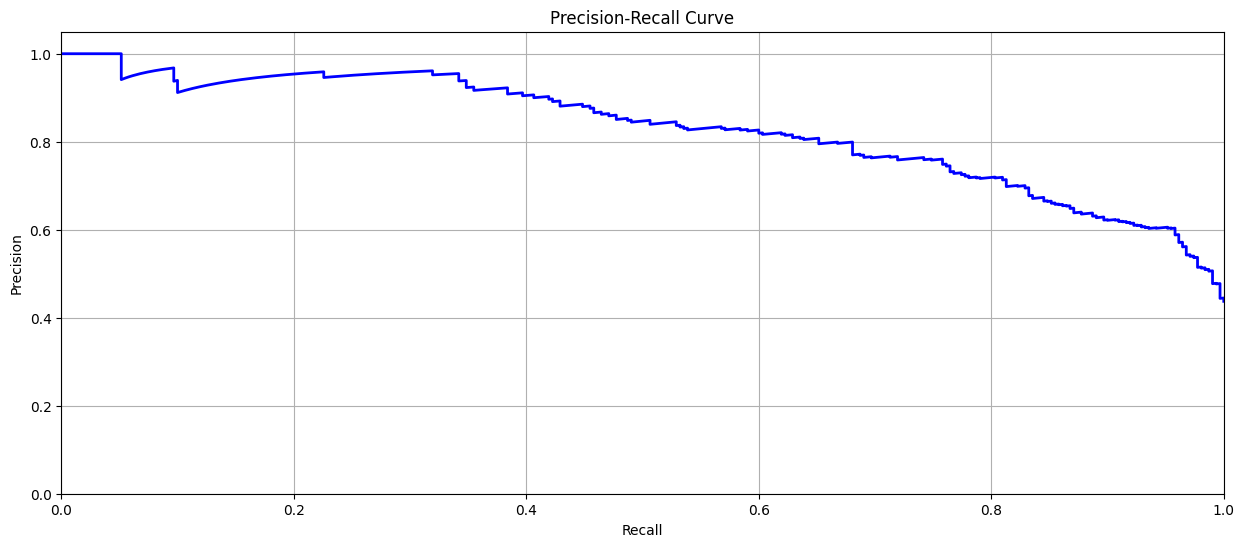

In [25]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(15, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

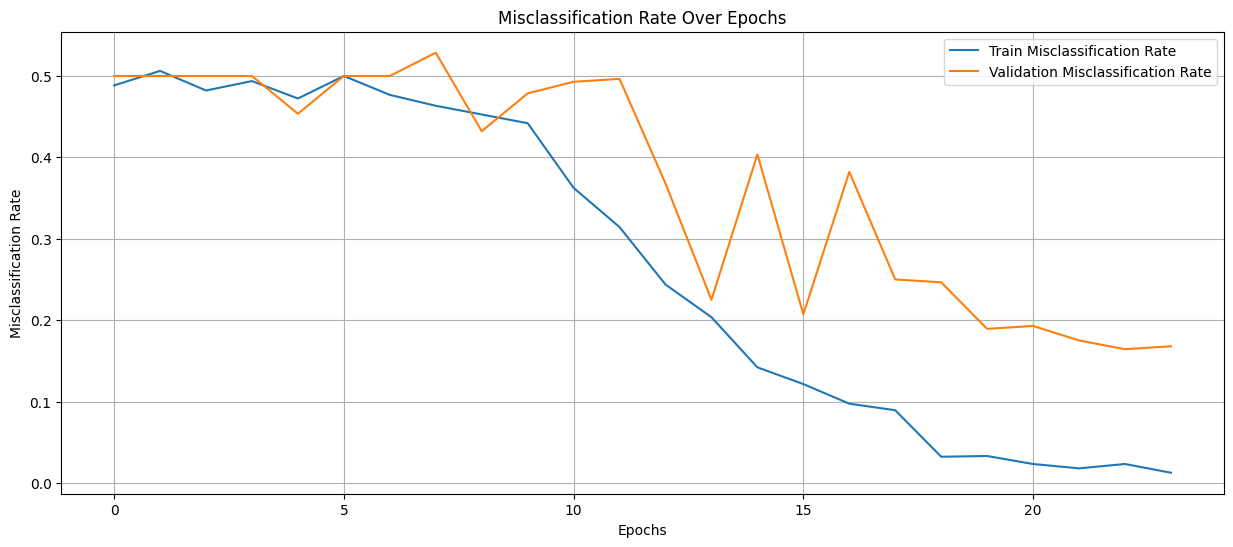

In [23]:
# Misclassification rate for train and validation data
train_misclassification = [1 - acc for acc in history_fs.history['accuracy']]
val_misclassification = [1 - val_acc for val_acc in history_fs.history['val_accuracy']]

# Plot misclassification rates
plt.figure(figsize=(15, 6))
plt.plot(train_misclassification, label='Train Misclassification Rate')
plt.plot(val_misclassification, label='Validation Misclassification Rate')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


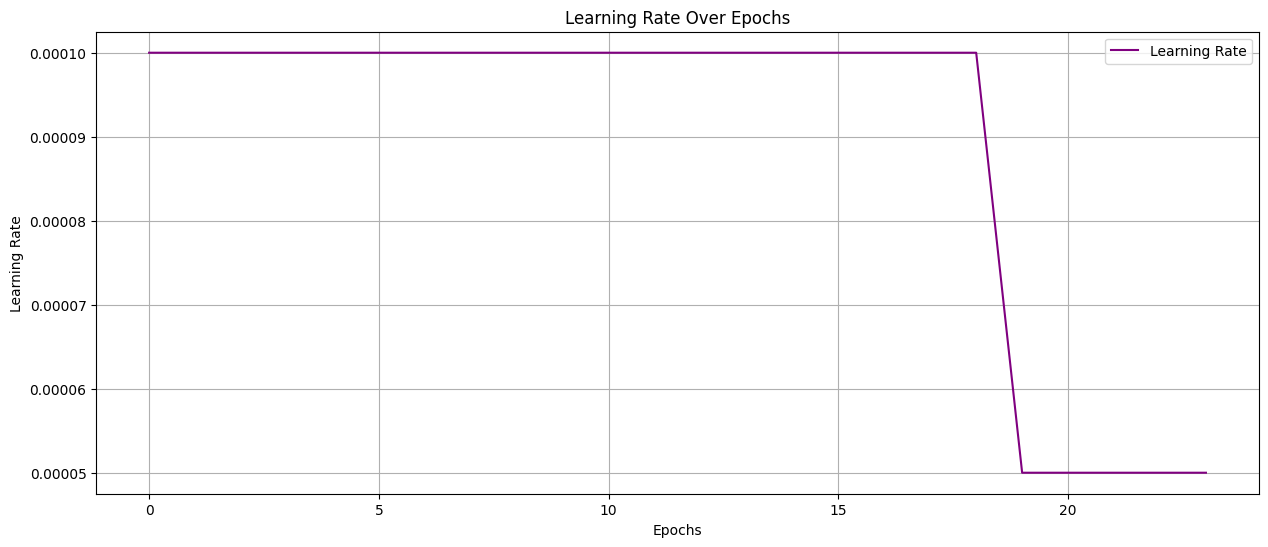

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(history_fs.history['lr'], label='Learning Rate', color='purple')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


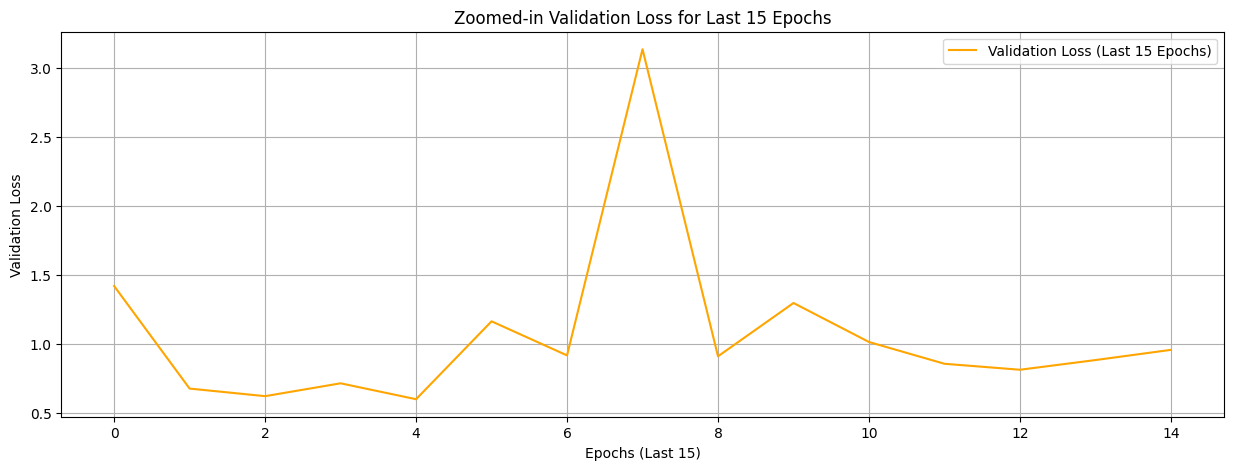

In [30]:
# Assuming the last 10 epochs for zoom-in
plt.figure(figsize=(15, 5))
plt.plot(history_fs.history['val_loss'][-15:], label='Validation Loss (Last 15 Epochs)', color='orange')
plt.title('Zoomed-in Validation Loss for Last 15 Epochs')
plt.xlabel('Epochs (Last 15)')
plt.ylabel('Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


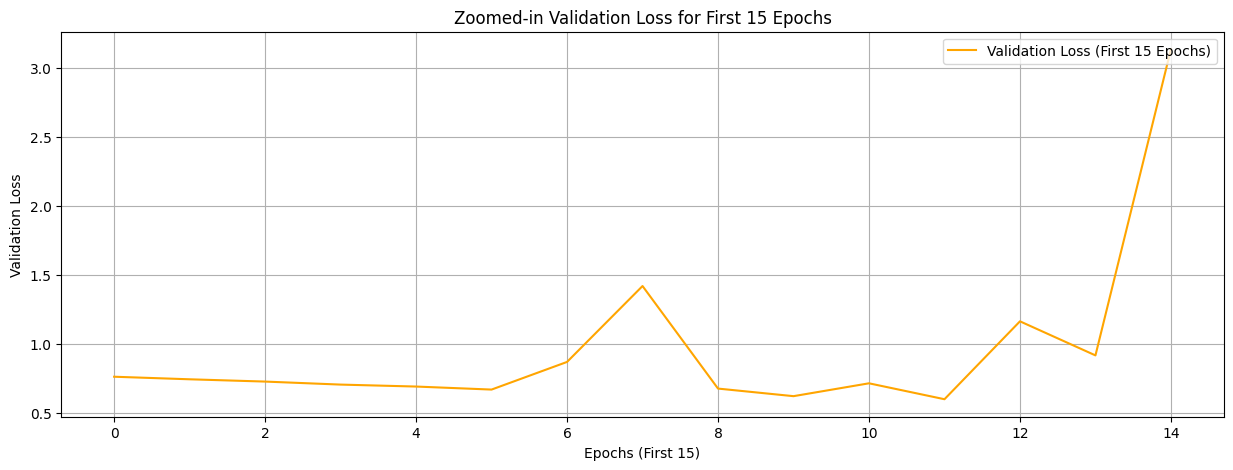

In [31]:
# Assuming the last 10 epochs for zoom-in
plt.figure(figsize=(15, 5))
plt.plot(history_fs.history['val_loss'][0:15], label='Validation Loss (First 15 Epochs)', color='orange')
plt.title('Zoomed-in Validation Loss for First 15 Epochs')
plt.xlabel('Epochs (First 15)')
plt.ylabel('Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


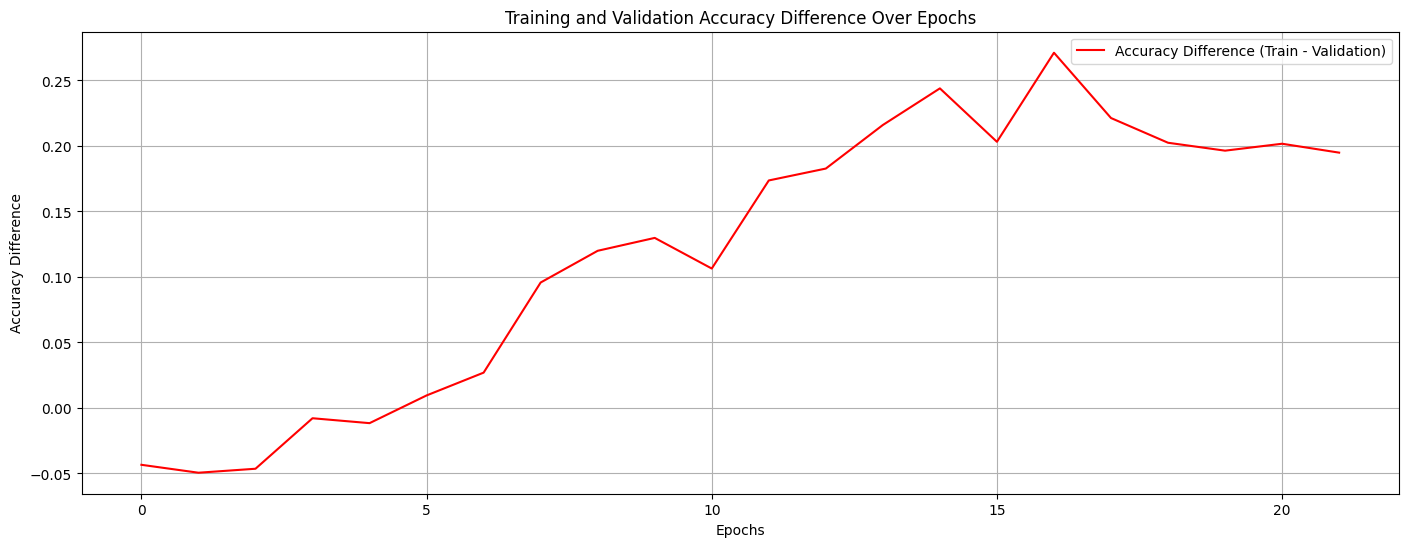

In [32]:
plt.figure(figsize=(17, 6))
accuracy_diff = np.array(history_fs.history['accuracy']) - np.array(history_fs.history['val_accuracy'])
plt.plot(accuracy_diff, label='Accuracy Difference (Train - Validation)', color='red')
plt.title('Training and Validation Accuracy Difference Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()


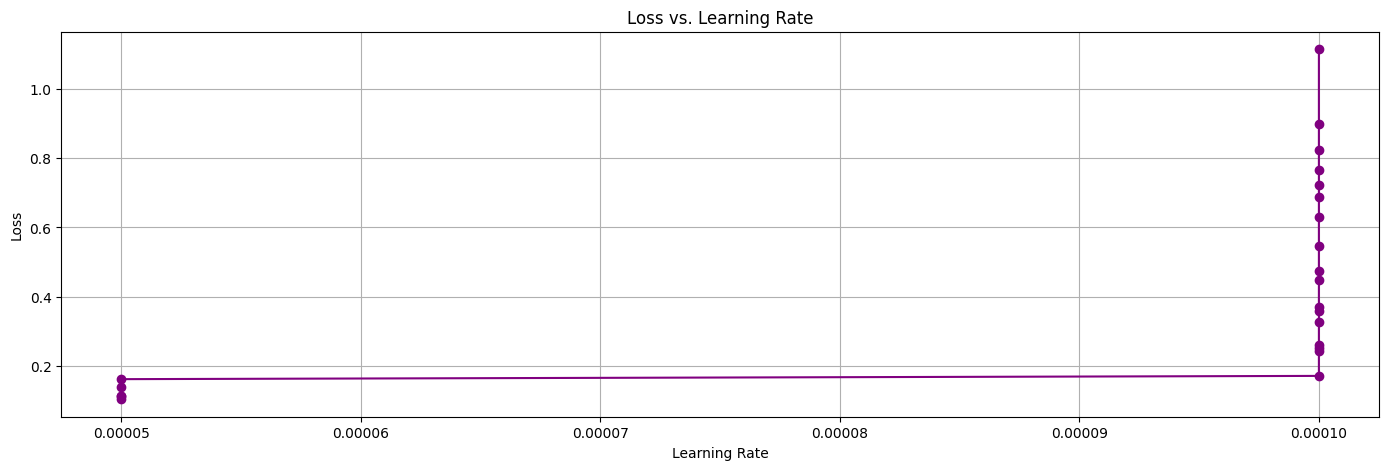

In [33]:
plt.figure(figsize=(17, 5))
plt.plot(history_fs.history['lr'], history_fs.history['loss'], marker='o', color='purple')
plt.title('Loss vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


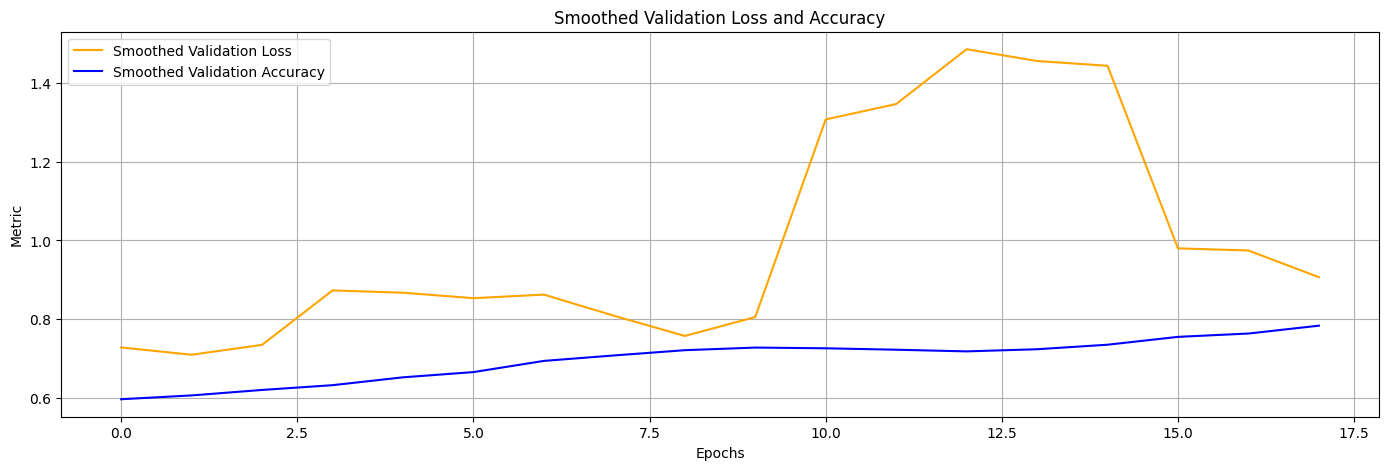

In [34]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(17, 5))
plt.plot(moving_average(history_fs.history['val_loss'], 5), label='Smoothed Validation Loss', color='orange')
plt.plot(moving_average(history_fs.history['val_accuracy'], 5), label='Smoothed Validation Accuracy', color='blue')
plt.title('Smoothed Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


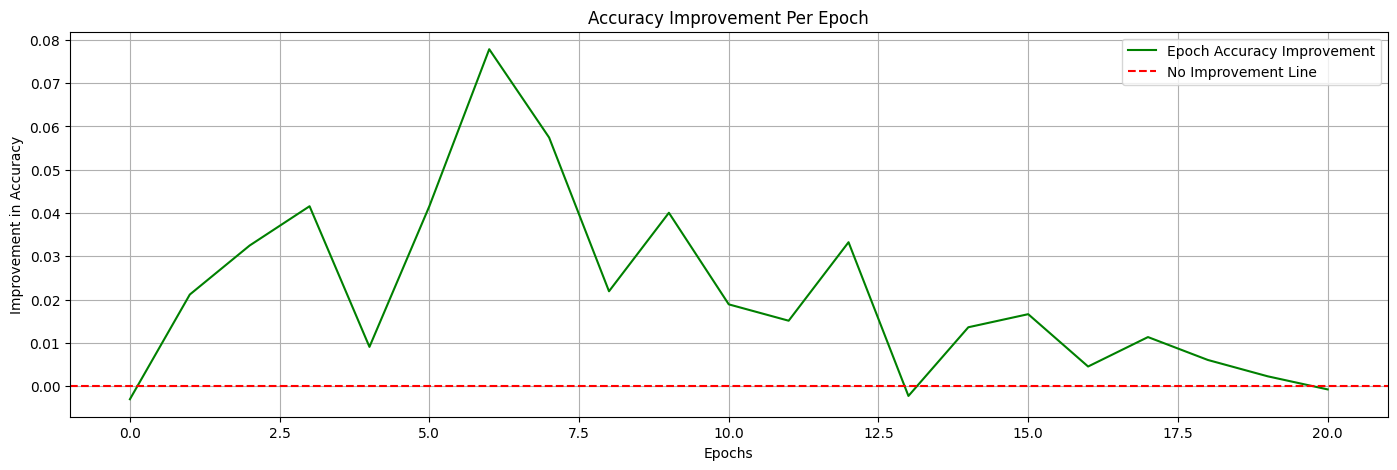

In [35]:
epoch_accuracy_improvement = np.diff(history_fs.history['accuracy'])
plt.figure(figsize=(17, 5))
plt.plot(epoch_accuracy_improvement, label='Epoch Accuracy Improvement', color='green')
plt.axhline(0, color='red', linestyle='--', label='No Improvement Line')
plt.title('Accuracy Improvement Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Improvement in Accuracy')
plt.legend()
plt.grid(True)
plt.show()


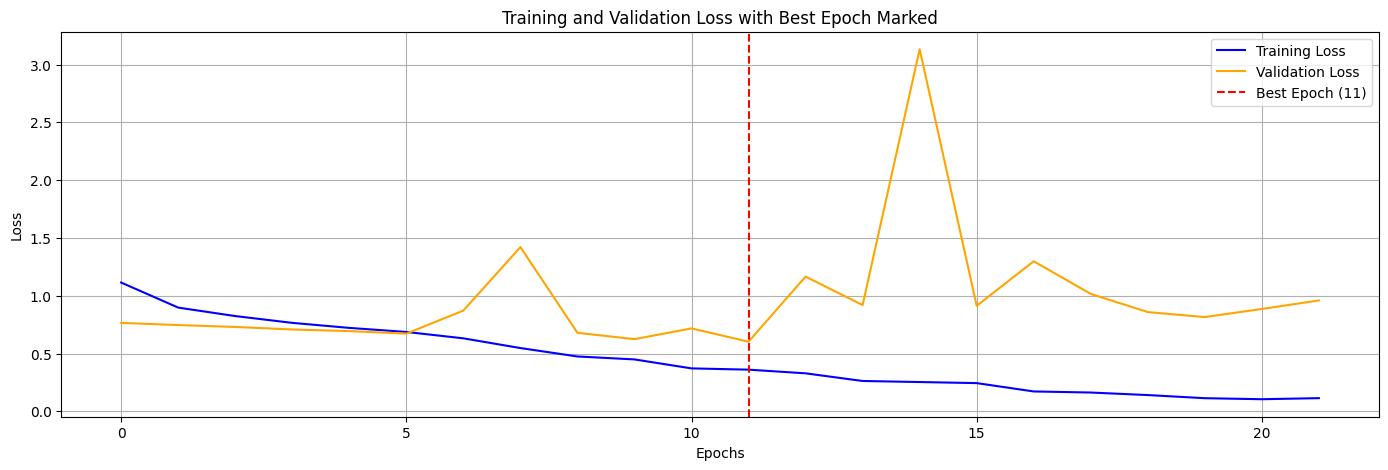

In [37]:
best_epoch = np.argmin(history_fs.history['val_loss'])

plt.figure(figsize=(17, 5))
plt.plot(history_fs.history['loss'], label='Training Loss', color='blue')
plt.plot(history_fs.history['val_loss'], label='Validation Loss', color='orange')
plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Training and Validation Loss with Best Epoch Marked')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


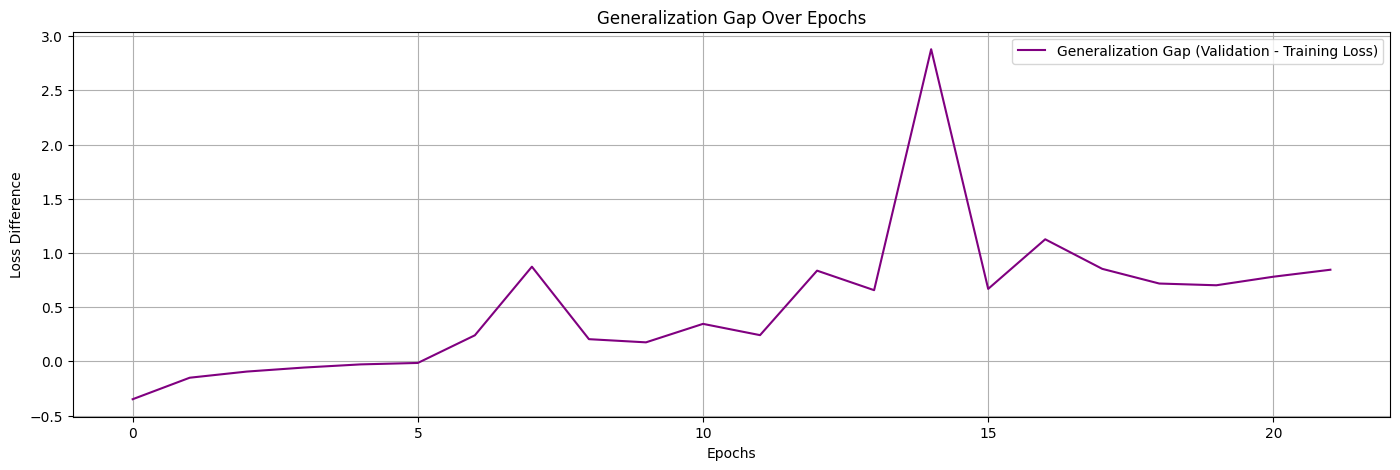

In [38]:
plt.figure(figsize=(17, 5))
generalization_gap = np.array(history_fs.history['val_loss']) - np.array(history_fs.history['loss'])
plt.plot(generalization_gap, color='purple', label='Generalization Gap (Validation - Training Loss)')
plt.title('Generalization Gap Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()
plt.grid(True)
plt.show()


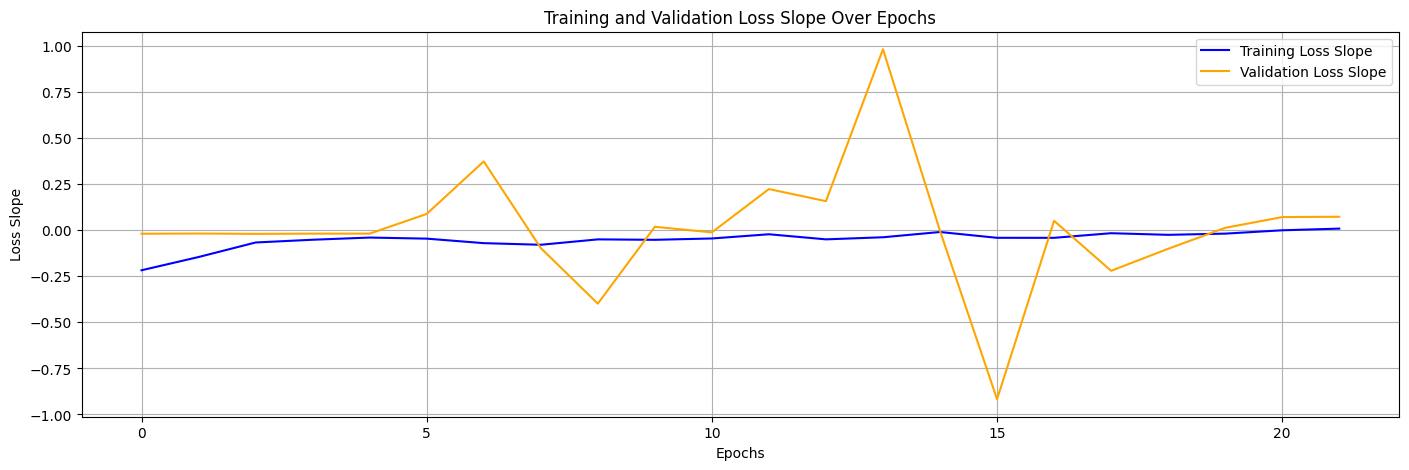

In [39]:
training_loss_slope = np.gradient(history_fs.history['loss'])
validation_loss_slope = np.gradient(history_fs.history['val_loss'])

plt.figure(figsize=(17, 5))
plt.plot(training_loss_slope, label='Training Loss Slope', color='blue')
plt.plot(validation_loss_slope, label='Validation Loss Slope', color='orange')
plt.title('Training and Validation Loss Slope Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Slope')
plt.legend()
plt.grid(True)
plt.show()


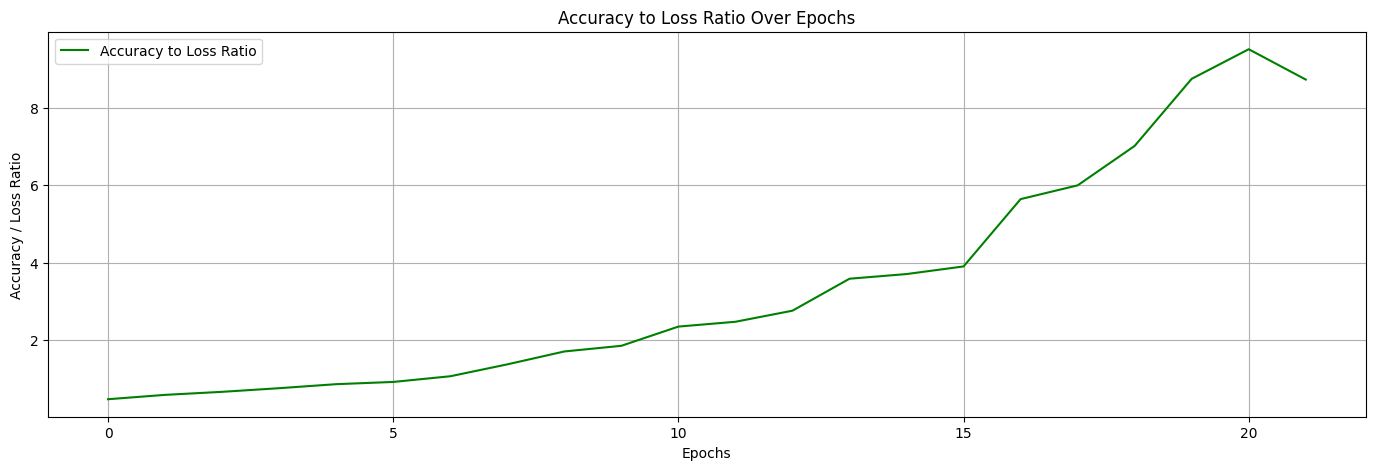

In [40]:
accuracy_loss_ratio = np.array(history_fs.history['accuracy']) / (np.array(history_fs.history['loss']) + 1e-8)
plt.figure(figsize=(17, 5))
plt.plot(accuracy_loss_ratio, color='green', label='Accuracy to Loss Ratio')
plt.title('Accuracy to Loss Ratio Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss Ratio')
plt.legend()
plt.grid(True)
plt.show()


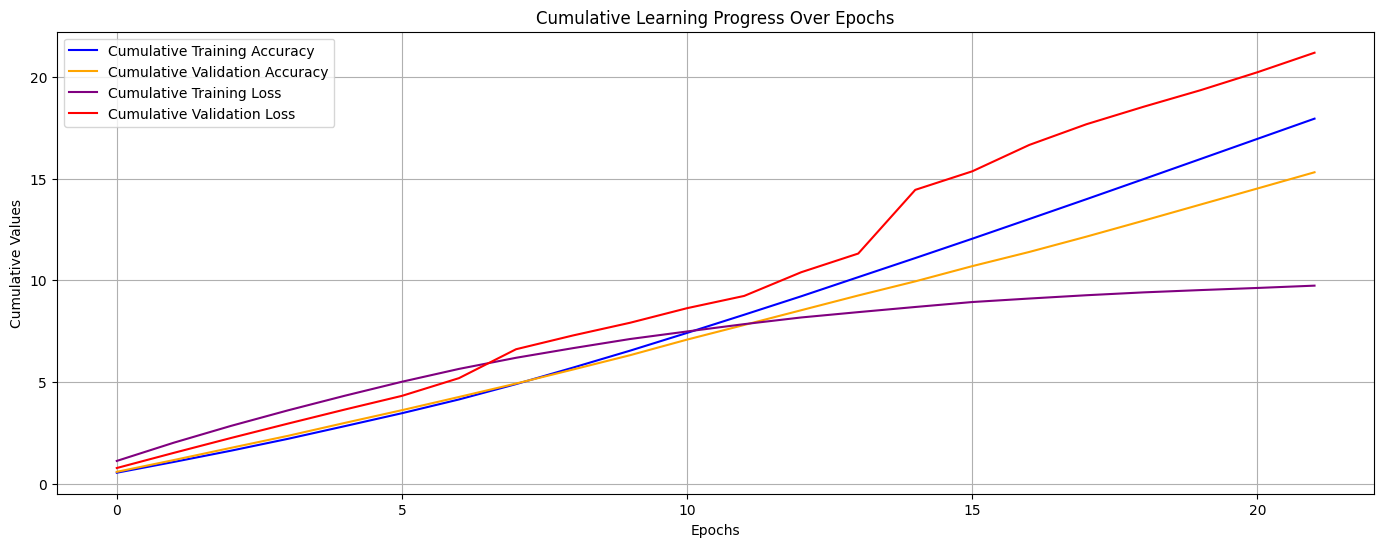

In [41]:
cumulative_accuracy = np.cumsum(history_fs.history['accuracy'])
cumulative_val_accuracy = np.cumsum(history_fs.history['val_accuracy'])
cumulative_loss = np.cumsum(history_fs.history['loss'])
cumulative_val_loss = np.cumsum(history_fs.history['val_loss'])

plt.figure(figsize=(17, 6))
plt.plot(cumulative_accuracy, label='Cumulative Training Accuracy', color='blue')
plt.plot(cumulative_val_accuracy, label='Cumulative Validation Accuracy', color='orange')
plt.plot(cumulative_loss, label='Cumulative Training Loss', color='purple')
plt.plot(cumulative_val_loss, label='Cumulative Validation Loss', color='red')
plt.title('Cumulative Learning Progress Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Values')
plt.legend()
plt.grid(True)
plt.show()


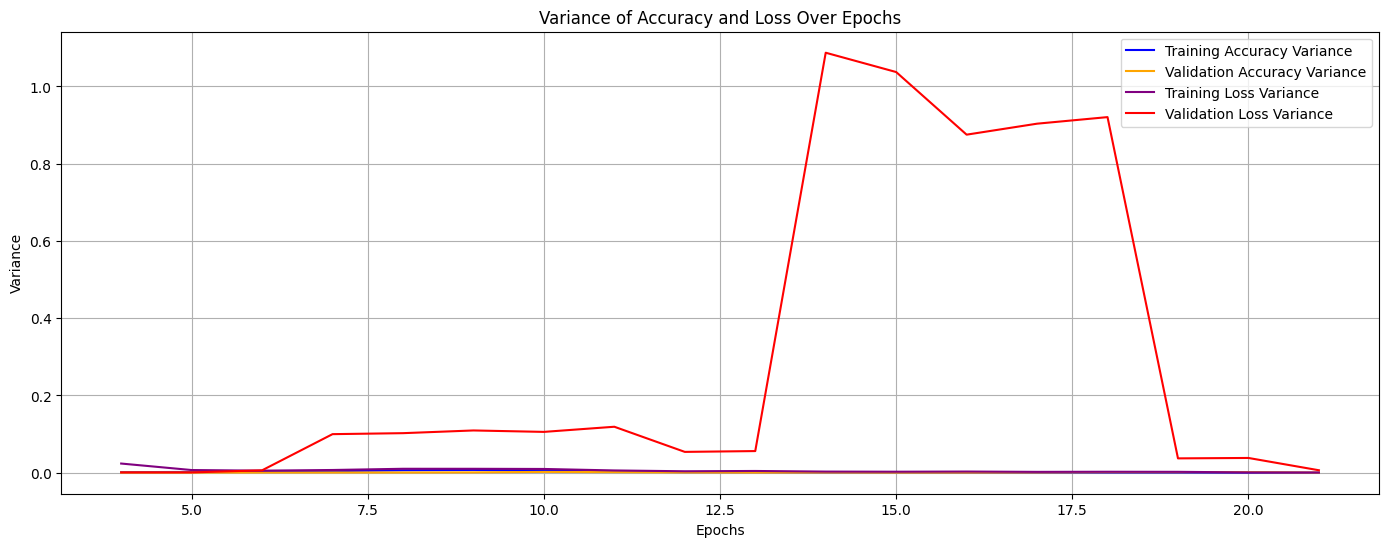

In [42]:
window_size = 5  # Adjust this based on your preferences
accuracy_variance = pd.Series(history_fs.history['accuracy']).rolling(window=window_size).var()
val_accuracy_variance = pd.Series(history_fs.history['val_accuracy']).rolling(window=window_size).var()
loss_variance = pd.Series(history_fs.history['loss']).rolling(window=window_size).var()
val_loss_variance = pd.Series(history_fs.history['val_loss']).rolling(window=window_size).var()

plt.figure(figsize=(17, 6))
plt.plot(accuracy_variance, label='Training Accuracy Variance', color='blue')
plt.plot(val_accuracy_variance, label='Validation Accuracy Variance', color='orange')
plt.plot(loss_variance, label='Training Loss Variance', color='purple')
plt.plot(val_loss_variance, label='Validation Loss Variance', color='red')
plt.title('Variance of Accuracy and Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()


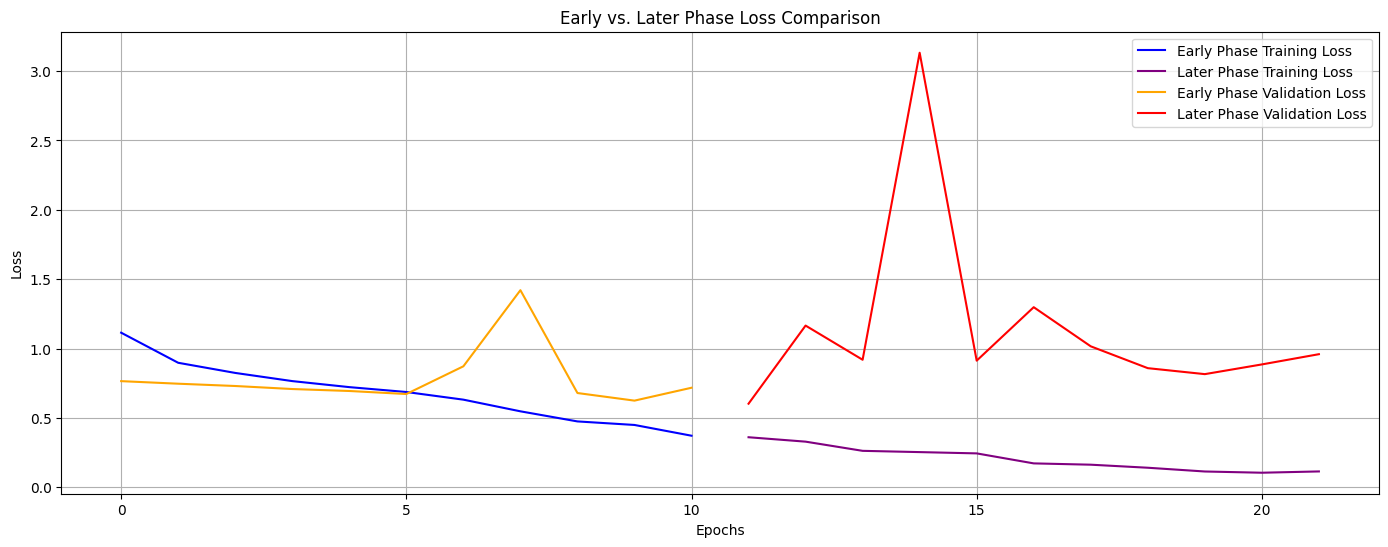

In [43]:
midpoint = len(history_fs.history['loss']) // 2
epochs = list(range(len(history_fs.history['loss'])))

plt.figure(figsize=(17, 6))
plt.plot(epochs[:midpoint], history_fs.history['loss'][:midpoint], label='Early Phase Training Loss', color='blue')
plt.plot(epochs[midpoint:], history_fs.history['loss'][midpoint:], label='Later Phase Training Loss', color='purple')
plt.plot(epochs[:midpoint], history_fs.history['val_loss'][:midpoint], label='Early Phase Validation Loss', color='orange')
plt.plot(epochs[midpoint:], history_fs.history['val_loss'][midpoint:], label='Later Phase Validation Loss', color='red')
plt.title('Early vs. Later Phase Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


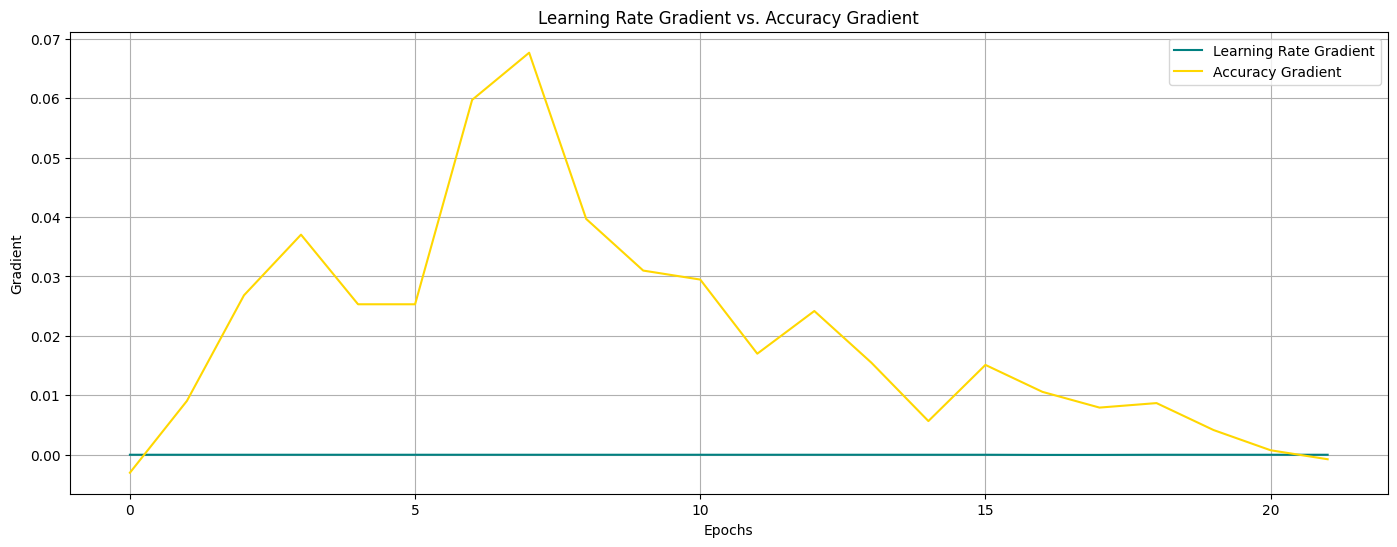

In [44]:
lr_gradient = np.gradient(history_fs.history['lr'])
accuracy_gradient = np.gradient(history_fs.history['accuracy'])

plt.figure(figsize=(17, 6))
plt.plot(lr_gradient, label='Learning Rate Gradient', color='teal')
plt.plot(accuracy_gradient, label='Accuracy Gradient', color='gold')
plt.title('Learning Rate Gradient vs. Accuracy Gradient')
plt.xlabel('Epochs')
plt.ylabel('Gradient')
plt.legend()
plt.grid(True)
plt.show()


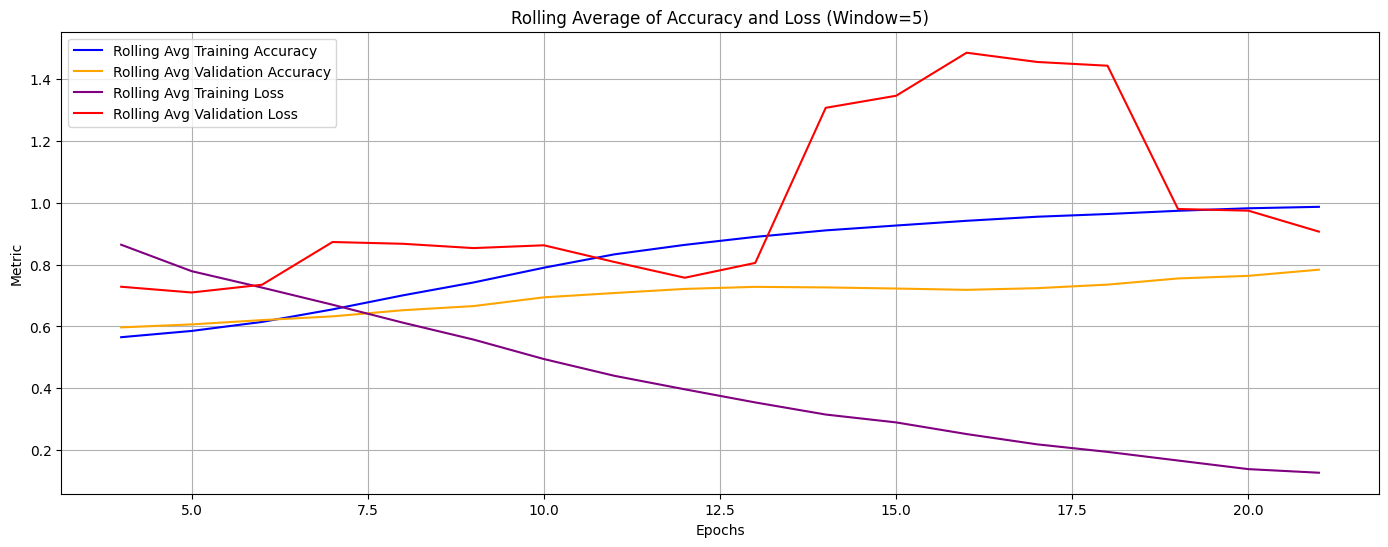

In [45]:
window = 5  # Choose the window size for smoothing

plt.figure(figsize=(17, 6))
plt.plot(pd.Series(history_fs.history['accuracy']).rolling(window=window).mean(), label='Rolling Avg Training Accuracy', color='blue')
plt.plot(pd.Series(history_fs.history['val_accuracy']).rolling(window=window).mean(), label='Rolling Avg Validation Accuracy', color='orange')
plt.plot(pd.Series(history_fs.history['loss']).rolling(window=window).mean(), label='Rolling Avg Training Loss', color='purple')
plt.plot(pd.Series(history_fs.history['val_loss']).rolling(window=window).mean(), label='Rolling Avg Validation Loss', color='red')
plt.title(f'Rolling Average of Accuracy and Loss (Window={window})')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


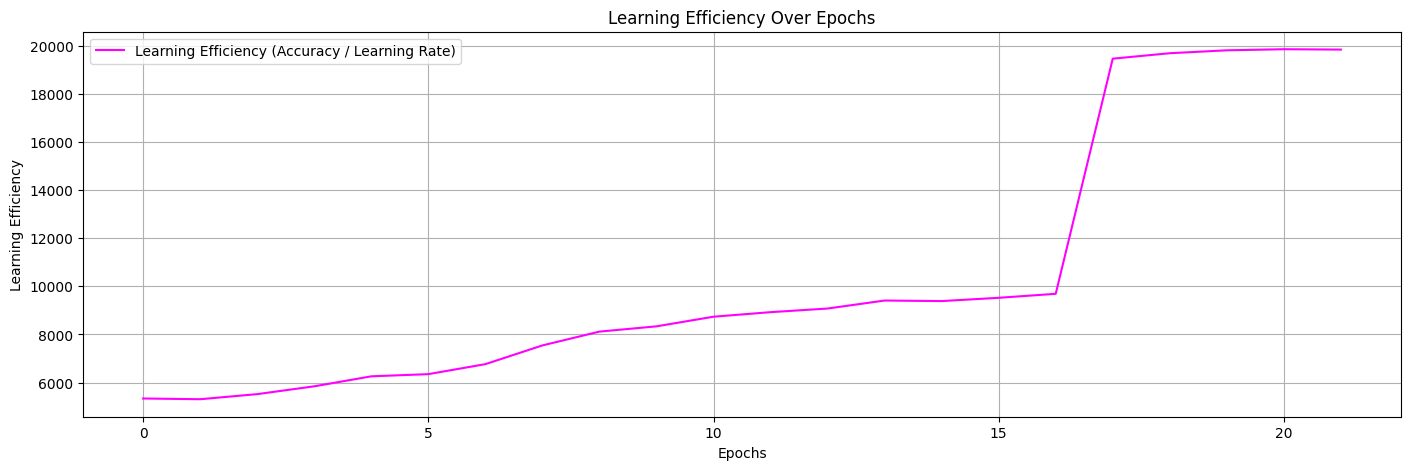

In [46]:
learning_efficiency = np.array(history_fs.history['accuracy']) / (np.array(history_fs.history['lr']) + 1e-8)

plt.figure(figsize=(17, 5))
plt.plot(learning_efficiency, label='Learning Efficiency (Accuracy / Learning Rate)', color='magenta')
plt.title('Learning Efficiency Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Efficiency')
plt.legend()
plt.grid(True)
plt.show()


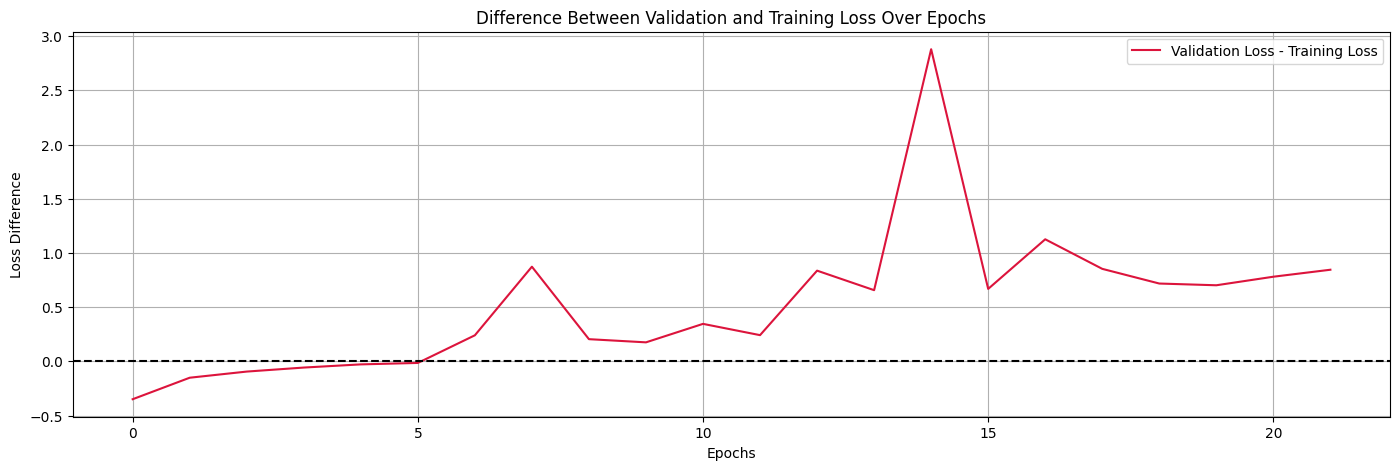

In [47]:
loss_diff = np.array(history_fs.history['val_loss']) - np.array(history_fs.history['loss'])

plt.figure(figsize=(17, 5))
plt.plot(loss_diff, label='Validation Loss - Training Loss', color='crimson')
plt.title('Difference Between Validation and Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


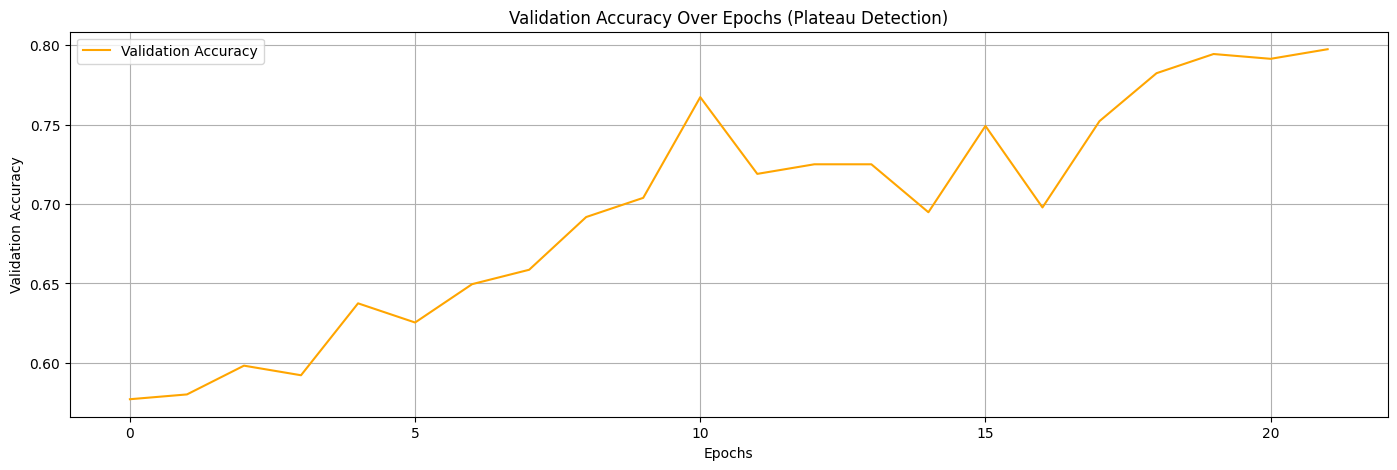

In [48]:
plt.figure(figsize=(17, 5))
plt.plot(history_fs.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy Over Epochs (Plateau Detection)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


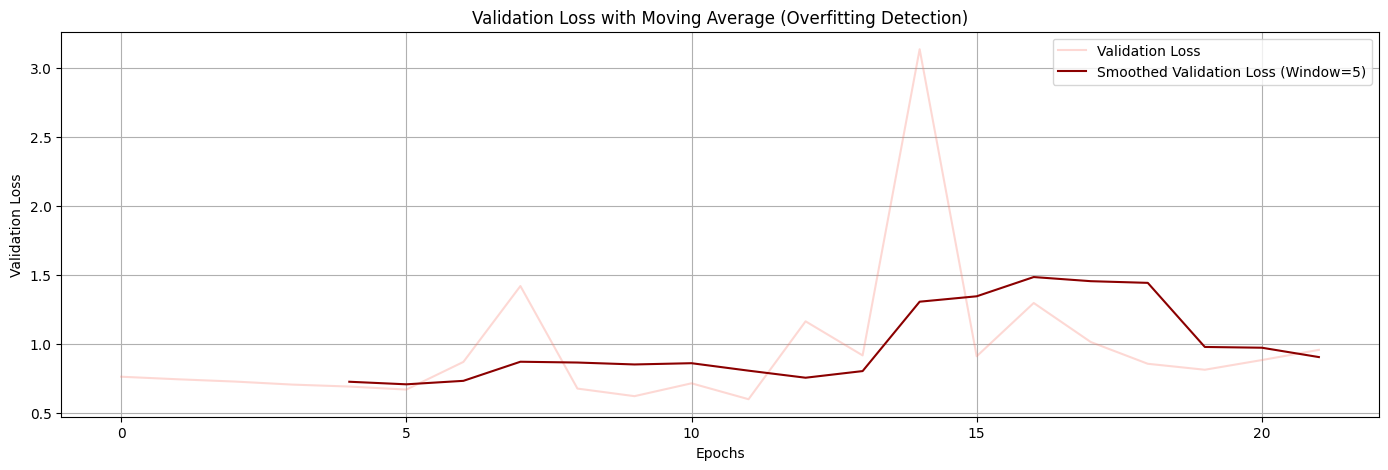

In [49]:
window_size = 5  # Adjust the window for smoothing
val_loss_smooth = pd.Series(history_fs.history['val_loss']).rolling(window=window_size).mean()

plt.figure(figsize=(17, 5))
plt.plot(history_fs.history['val_loss'], label='Validation Loss', color='salmon', alpha=0.3)
plt.plot(val_loss_smooth, label=f'Smoothed Validation Loss (Window={window_size})', color='darkred')
plt.title('Validation Loss with Moving Average (Overfitting Detection)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


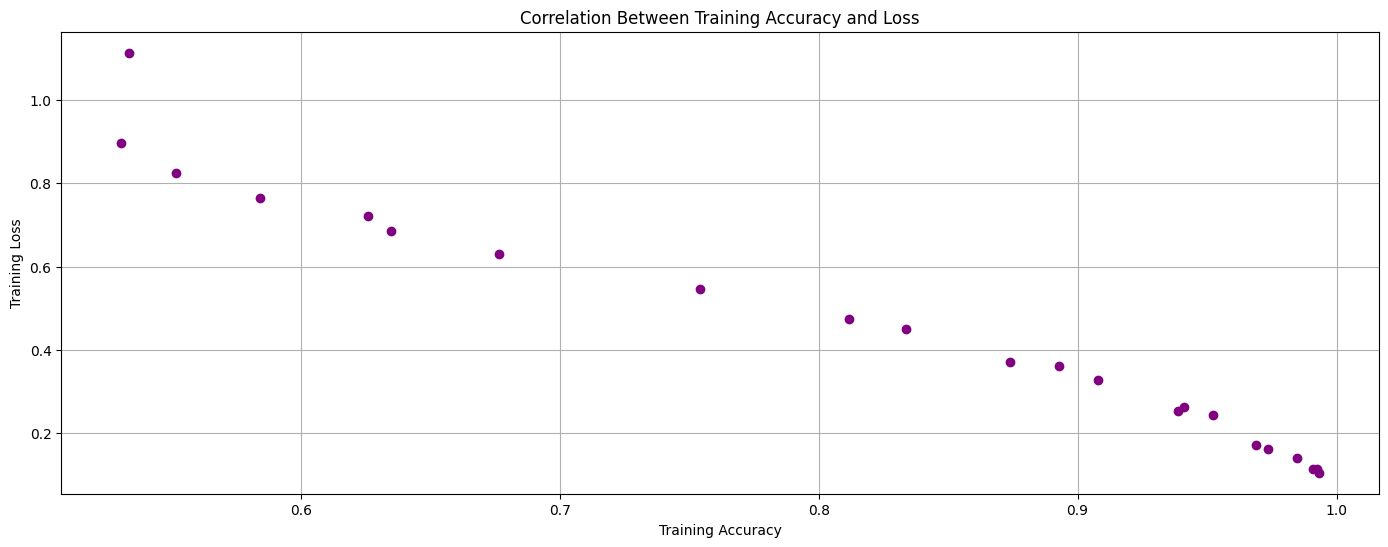

In [50]:
plt.figure(figsize=(17, 6))
plt.scatter(history_fs.history['accuracy'], history_fs.history['loss'], color='purple')
plt.title('Correlation Between Training Accuracy and Loss')
plt.xlabel('Training Accuracy')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()


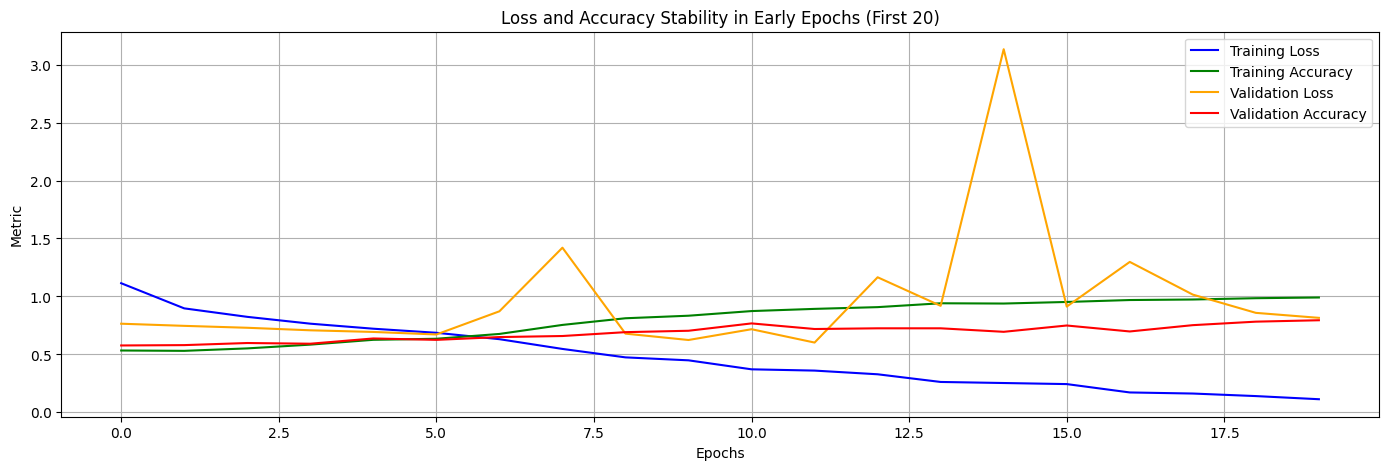

In [51]:
early_epochs = 20  # Adjust to check the initial epochs
plt.figure(figsize=(17, 5))
plt.plot(history_fs.history['loss'][:early_epochs], label='Training Loss', color='blue')
plt.plot(history_fs.history['accuracy'][:early_epochs], label='Training Accuracy', color='green')
plt.plot(history_fs.history['val_loss'][:early_epochs], label='Validation Loss', color='orange')
plt.plot(history_fs.history['val_accuracy'][:early_epochs], label='Validation Accuracy', color='red')
plt.title(f'Loss and Accuracy Stability in Early Epochs (First {early_epochs})')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


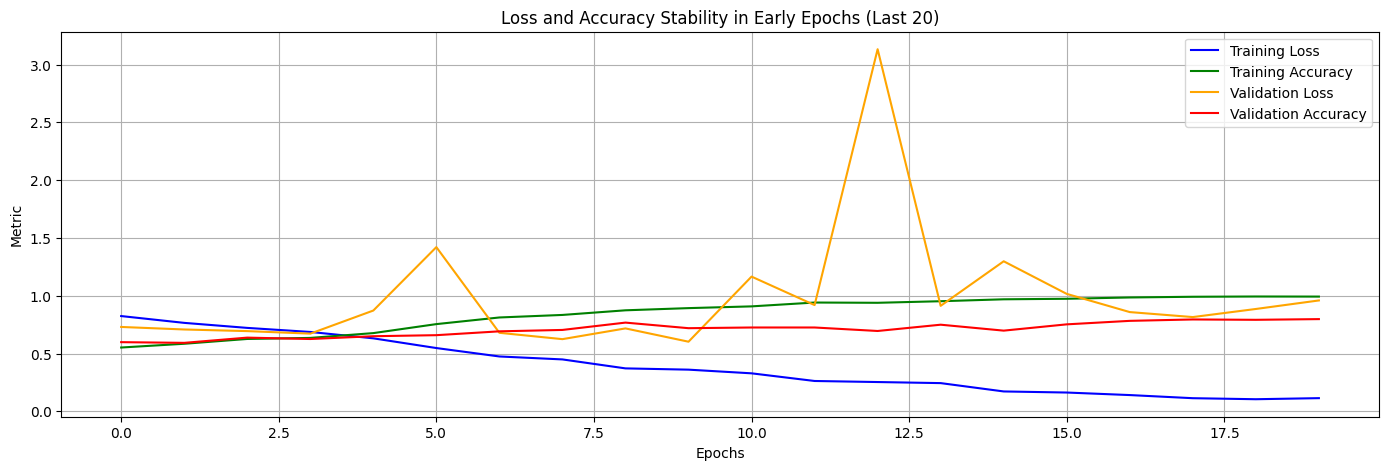

In [52]:
early_epochs = 20  # Adjust to check the initial epochs
plt.figure(figsize=(17, 5))
plt.plot(history_fs.history['loss'][-early_epochs:], label='Training Loss', color='blue')
plt.plot(history_fs.history['accuracy'][-early_epochs:], label='Training Accuracy', color='green')
plt.plot(history_fs.history['val_loss'][-early_epochs:], label='Validation Loss', color='orange')
plt.plot(history_fs.history['val_accuracy'][-early_epochs:], label='Validation Accuracy', color='red')
plt.title(f'Loss and Accuracy Stability in Early Epochs (Last {early_epochs})')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()

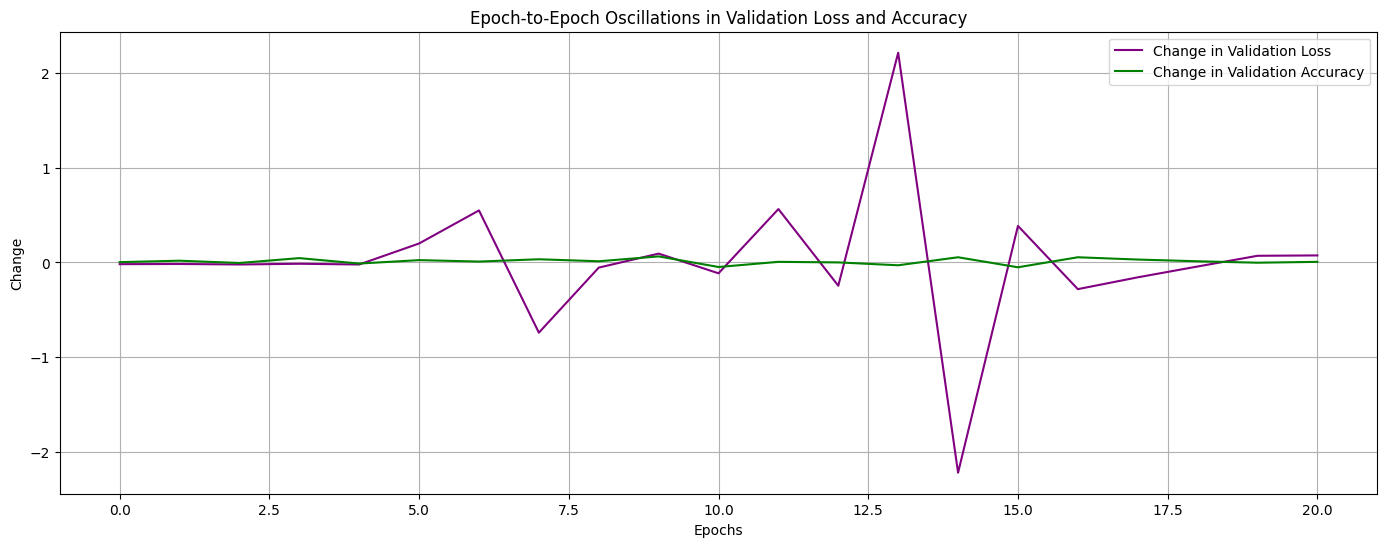

In [53]:
val_loss_change = np.diff(history_fs.history['val_loss'])
val_accuracy_change = np.diff(history_fs.history['val_accuracy'])

plt.figure(figsize=(17, 6))
plt.plot(val_loss_change, label='Change in Validation Loss', color='purple')
plt.plot(val_accuracy_change, label='Change in Validation Accuracy', color='green')
plt.title('Epoch-to-Epoch Oscillations in Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Change')
plt.legend()
plt.grid(True)
plt.show()


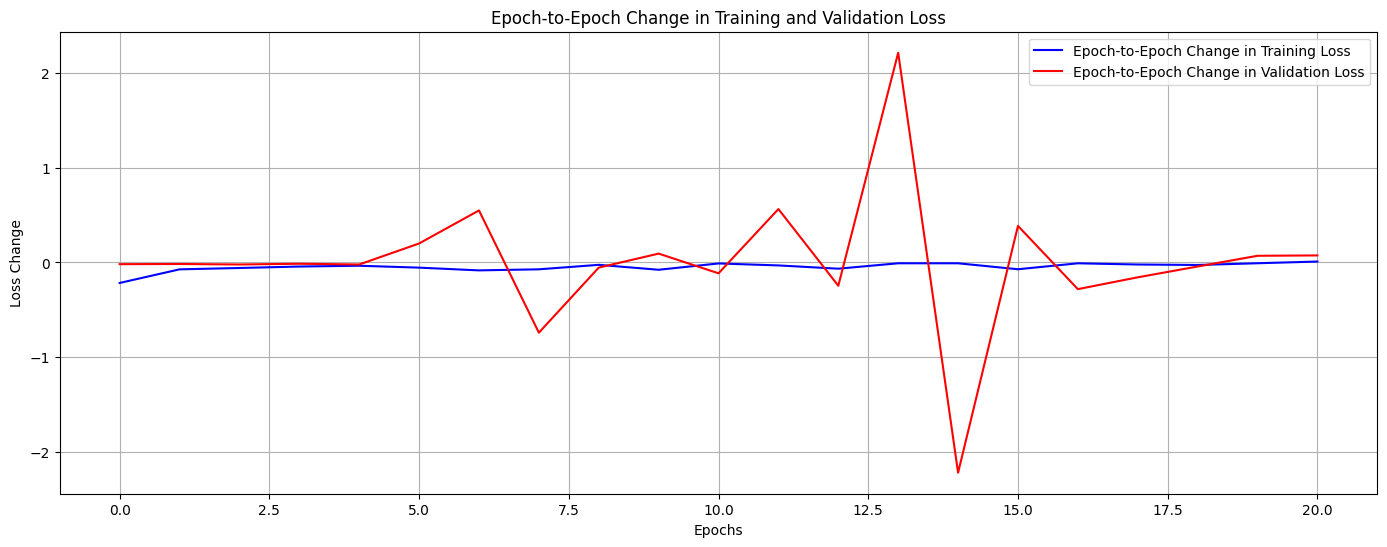

In [54]:
train_loss_change = np.diff(history_fs.history['loss'])
val_loss_change = np.diff(history_fs.history['val_loss'])

plt.figure(figsize=(17, 6))
plt.plot(train_loss_change, label='Epoch-to-Epoch Change in Training Loss', color='blue')
plt.plot(val_loss_change, label='Epoch-to-Epoch Change in Validation Loss', color='red')
plt.title('Epoch-to-Epoch Change in Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Change')
plt.legend()
plt.grid(True)
plt.show()


## **Neural Textures (HQ)**

In [55]:
pickled_data_nt = load_data_from_pickles('D:/Projects/Face-Swap-Detection-Model/NeuralTexture_pkl')

In [57]:
# Print the structure of one sample entry
sample_video = list(pickled_data_nt.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frames_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000_003' structure:
Frames count: 300
Frames labels count: 300
Micro-expression count: 900
Micro-expression labels count: 900


In [59]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items_nt = list(pickled_data_nt.items())
video_names, labels = zip(*[(video_name, video_info['frames_label'][0]) for video_name, video_info in pickled_data_nt.items()])

In [60]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [63]:
# Prepare dictionaries for each split
train_data = {name: pickled_data_nt[name] for name in train_names}
val_data = {name: pickled_data_nt[name] for name in val_names}
test_data = {name: pickled_data_nt[name] for name in test_names}

In [64]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

1323
331
709


In [65]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

In [66]:
for batch_data, batch_labels in train_generator:
    original_count = 0
    manipulated_count = 0
    for i, label in enumerate(batch_labels):
        if label == 0:  # Original video
            original_count += 1
        elif label == 1:  # Manipulated video
            manipulated_count += 1
    print(f"Original videos in batch: {original_count}")
    print(f"Manipulated videos in batch: {manipulated_count}")


Original videos in batch: 8
Manipulated videos in batch: 8
Original videos in batch: 9
Manipulated videos in batch: 7
Original videos in batch: 10
Manipulated videos in batch: 6
Original videos in batch: 9
Manipulated videos in batch: 7
Original videos in batch: 9
Manipulated videos in batch: 7
Original videos in batch: 7
Manipulated videos in batch: 9
Original videos in batch: 11
Manipulated videos in batch: 5
Original videos in batch: 6
Manipulated videos in batch: 10
Original videos in batch: 10
Manipulated videos in batch: 6
Original videos in batch: 12
Manipulated videos in batch: 4
Original videos in batch: 11
Manipulated videos in batch: 5
Original videos in batch: 13
Manipulated videos in batch: 3
Original videos in batch: 11
Manipulated videos in batch: 5
Original videos in batch: 9
Manipulated videos in batch: 7
Original videos in batch: 8
Manipulated videos in batch: 8
Original videos in batch: 7
Manipulated videos in batch: 9
Original videos in batch: 10
Manipulated videos 

X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)


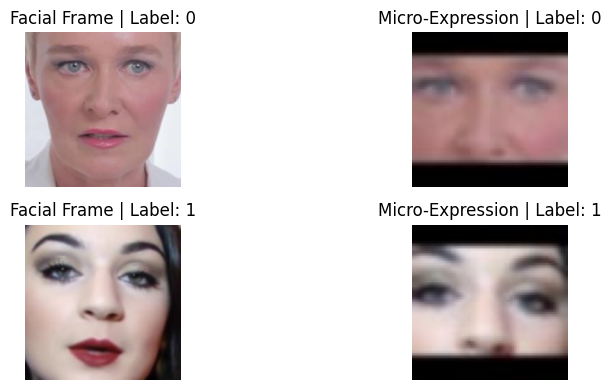

In [67]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Take a batch and unpack it
for batch in train_generator.take(1):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy().astype("uint8")

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy().astype("uint8")

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Display images for both labels
plt.figure(figsize=(10, 4))

# Display facial and micro-expression frames for label 0
plt.subplot(2, 2, 1)
plt.imshow(sample_frame_0)
plt.title("Facial Frame | Label: 0")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(sample_micro_exp_0)
plt.title("Micro-Expression | Label: 0")
plt.axis("off")

# Display facial and micro-expression frames for label 1
plt.subplot(2, 2, 3)
plt.imshow(sample_frame_1)
plt.title("Facial Frame | Label: 1")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample_micro_exp_1)
plt.title("Micro-Expression | Label: 1")
plt.axis("off")

plt.tight_layout()
plt.show()


In [68]:
model_nt = build_full_model()

In [69]:
optimizer_nt = Adam(learning_rate=1e-4)

In [71]:
model_nt.compile(
    optimizer=optimizer_nt,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_nt = model_nt.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/1000
83/83 [==============================] - 848s 6s/step - loss: 1.1241 - accuracy: 0.5163 - val_loss: 0.7584 - val_accuracy: 0.5921 - lr: 1.0000e-04
Epoch 2/1000
83/83 [==============================] - 197s 2s/step - loss: 0.8925 - accuracy: 0.5306 - val_loss: 0.7648 - val_accuracy: 0.5559 - lr: 1.0000e-04
Epoch 3/1000
83/83 [==============================] - 190s 2s/step - loss: 0.8212 - accuracy: 0.5291 - val_loss: 0.7749 - val_accuracy: 0.5227 - lr: 1.0000e-04
Epoch 4/1000
83/83 [==============================] - 192s 2s/step - loss: 0.7803 - accuracy: 0.5676 - val_loss: 0.7574 - val_accuracy: 0.5468 - lr: 1.0000e-04
Epoch 5/1000
83/83 [==============================] - 191s 2s/step - loss: 0.7752 - accuracy: 0.5654 - val_loss: 0.7483 - val_accuracy: 0.5921 - lr: 1.0000e-04
Epoch 6/1000
83/83 [==============================] - 190s 2s/step - loss: 0.7336 - accuracy: 0.6002 - val_loss: 0.7584 - val_accuracy: 0.5740 - lr: 1.0000e-04
Epoch 7/1000
83/83 [====================